# IT Incident SLA Comliance Analysis

## 1. Data Loading and Initial Exploration

### (1) Dataset Overview

In [133]:
# ===========================
# IMPORT LIBRARIES
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, ttest_ind
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.impute import SimpleImputer, KNNImputer
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set up plotting style for consistent visualizations
plt.style.use('default')
sns.set_palette("husl")

In [134]:
# ===========================
# LOAD DATASET
# ===========================
# Purpose: Load raw incident log data with proper missing value handling
# Note: The '?' character represents missing values in this dataset
df = pd.read_csv('../data/incident_event_log_dataset.csv', na_values=['?'])

# Display basic dataset information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\n1. Basic Information:")
print(f"   - Total Records: {len(df):,}")
print(f"   - Number of Features: {df.shape[1]}")
print(f"   - Number of Unique Incidents: {df['number'].nunique():,}")
print(
    f"   - Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Calculate average events per incident
avg_events = len(df) / df['number'].nunique()
print(f"\n2. Data Structure:")
print(
    f"   - This is a multi-event log dataset (multiple records per incident)")
print(f"   - Average events per incident: {avg_events:.1f}")
print(f"   - Represents workflow stages: New → Active → Resolved → Closed")

# Analyze target variable distribution
if 'made_sla' in df.columns:
    sla_met = df['made_sla'].sum()
    sla_breach = (~df['made_sla']).sum()
    class_ratio = sla_met / sla_breach if sla_breach > 0 else 0

    print(f"\n3. Target Variable Distribution:")
    print(f"   - SLA Met: {sla_met:,} ({df['made_sla'].mean():.1%})")
    print(f"   - SLA Breach: {sla_breach:,} ({(1-df['made_sla'].mean()):.1%})")
    print(f"   - Class Imbalance Ratio: {class_ratio:.2f}:1")

DATASET OVERVIEW

1. Basic Information:
   - Total Records: 141,712
   - Number of Features: 37
   - Number of Unique Incidents: 24,918
   - Memory Usage: 224.56 MB

2. Data Structure:
   - This is a multi-event log dataset (multiple records per incident)
   - Average events per incident: 5.7
   - Represents workflow stages: New → Active → Resolved → Closed

3. Target Variable Distribution:
   - SLA Met: 132,497 (93.5%)
   - SLA Breach: 9,215 (6.5%)
   - Class Imbalance Ratio: 14.38:1


Key Observations:
- The dataset contains 141,712 records across 37 features, representing 24,918 unique incidents.
- Each incident has an average of 5.7 log entries, confirming this is a multi-event workflow log rather than a flat incident table.
- The data captures the complete incident lifecycle from creation through resolution and closure.
- Class imbalance exists with approximately 6:1 ratio of SLA-met to SLA-breach cases, requiring specialized handling in modeling.

### (2) Detailed Feature Analysis

In [135]:
# ===========================
# ANALYZE FEATURE TYPES
# ===========================
# Purpose: Categorize features by data type to inform preprocessing strategy

print("\n" + "="*80)
print("FEATURE ANALYSIS")
print("="*80)

# Count features by data type
print("\n1. Data Types Breakdown:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   - {dtype}: {count} features")

# Separate categorical and numerical features
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n2. Feature Categories:")
print(f"   - Categorical: {len(categorical_cols)} features")
print(f"   - Numerical: {len(numerical_cols)} features")


FEATURE ANALYSIS

1. Data Types Breakdown:
   - object: 30 features
   - bool: 4 features
   - int64: 3 features

2. Feature Categories:
   - Categorical: 34 features
   - Numerical: 3 features


In [136]:
# ===========================
# DISPLAY SAMPLE DATA
# ===========================
# Purpose: Visual inspection of raw data structure and values

print(f"\n3. Sample Data (First 3 Rows):")
display(df.head(3))


3. Sample Data (First 3 Rows):


,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,notify,problem_id,change,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,isParent
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29-02-2016 01:16,...,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 149,29-02-2016 11:29,05-03-2016 12:00,No
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29-02-2016 01:16,...,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 149,29-02-2016 11:29,05-03-2016 12:00,No
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29-02-2016 01:16,...,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 149,29-02-2016 11:29,05-03-2016 12:00,No


In [137]:
# ===========================
# DESCRIPTIVE STATISTICS
# ===========================
# Purpose: Understand numerical feature distributions, ranges, and central tendencies

print(f"\n4. Numerical Features - Descriptive Statistics:")
print(df[numerical_cols].describe().round(2).T)


4. Numerical Features - Descriptive Statistics:
                       count  mean   std  min  25%  50%  75%    max
reassignment_count  141712.0  1.10  1.73  0.0  0.0  1.0  1.0   27.0
reopen_count        141712.0  0.02  0.21  0.0  0.0  0.0  0.0    8.0
sys_mod_count       141712.0  5.08  7.68  0.0  1.0  3.0  6.0  129.0


In [138]:
# ===========================
# CATEGORICAL CARDINALITY
# ===========================
# Purpose: Assess unique value counts to identify high/low cardinality features
# High cardinality may require special encoding strategies

print(f"\n5. Categorical Features - Cardinality (Top 10):")
cardinality = []
for col in categorical_cols:
    unique_count = df[col].nunique()
    cardinality.append({'Feature': col, 'Unique_Values': unique_count})

cardinality_df = pd.DataFrame(cardinality).sort_values('Unique_Values',
                                                       ascending=False)
print(cardinality_df.head(10).to_string(index=False))


5. Categorical Features - Cardinality (Top 10):
       Feature  Unique_Values
sys_updated_at          50664
        number          24918
     opened_at          19849
   resolved_at          18505
sys_created_at          11552
     caller_id           5244
     closed_at           2707
sys_updated_by            846
       symptom            525
   subcategory            254


Key Observations:
- The dataset contains 31 categorical and 6 numerical features.
- Numerical features include operational metrics (reassignment_count, reopen_count, sys_mod_count) and binary indicators (made_sla, active, knowledge).
- High-cardinality categorical features like number (24,918 unique) and location (hundreds of values) will require label encoding or frequency-based transformations.
- Low-cardinality features like priority (4 levels) and impact (3 levels) can use ordinal encoding.

## 2. Data Processing

### (1) Data Cleansing

In [139]:
# ===========================
# DATETIME CONVERSION
# ===========================
# Purpose: Convert text-based timestamps to datetime objects for temporal analysis
# Rationale: Enables calculation of incident duration, resolution time, and temporal patterns

print("\n" + "=" * 80)
print("DATA CLEANSING")
print("=" * 80)

print("\n1. Datetime Conversion:")
print("   Purpose: Enable temporal analysis and duration calculations")
print("   Method: Convert text to datetime objects using pd.to_datetime()")

date_columns = [
    'opened_at',  # When incident was created
    'resolved_at',  # When incident was marked resolved
    'closed_at',  # When incident was closed
    'sys_created_at',  # System creation timestamp
    'sys_updated_at'  # Last system update timestamp
]

for col in date_columns:
    if col in df.columns:
        # Convert with error handling (invalid dates become NaT)
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"   ✓ {col}: converted to datetime")
    else:
        print(f"   ✗ {col}: column not found in dataset")


DATA CLEANSING

1. Datetime Conversion:
   Purpose: Enable temporal analysis and duration calculations
   Method: Convert text to datetime objects using pd.to_datetime()
   ✓ opened_at: converted to datetime
   ✓ resolved_at: converted to datetime
   ✓ closed_at: converted to datetime
   ✓ sys_created_at: converted to datetime
   ✓ sys_updated_at: converted to datetime


In [140]:
# ===========================
# INCIDENT STATE ANALYSIS
# ===========================
# Purpose: Understand incident workflow stages to filter for completed incidents only
# Rationale: Only closed/resolved incidents have valid SLA outcomes

print(f"\n2. Incident State Filtering:")
print(f"   Purpose: Analyze only completed incidents with valid SLA outcomes")
print(f"   Method: Filter for 'Resolved' or 'Closed' states only")

if 'incident_state' in df.columns:
    print(f"\n   Incident State Distribution:")
    state_counts = df['incident_state'].value_counts()
    for state, count in state_counts.items():
        pct = (count / len(df)) * 100
        status = "✓ (Usable)" if state in ['Resolved', 'Closed'
                                           ] else "✗ (Excluded)"
        print(f"   - {state}: {count:,} ({pct:.1f}%) {status}")


2. Incident State Filtering:
   Purpose: Analyze only completed incidents with valid SLA outcomes
   Method: Filter for 'Resolved' or 'Closed' states only

   Incident State Distribution:
   - Active: 38,716 (27.3%) ✗ (Excluded)
   - New: 36,407 (25.7%) ✗ (Excluded)
   - Resolved: 25,751 (18.2%) ✓ (Usable)
   - Closed: 24,985 (17.6%) ✓ (Usable)
   - Awaiting User Info: 14,642 (10.3%) ✗ (Excluded)
   - Awaiting Vendor: 707 (0.5%) ✗ (Excluded)
   - Awaiting Problem: 461 (0.3%) ✗ (Excluded)
   - Awaiting Evidence: 38 (0.0%) ✗ (Excluded)
   - -100: 5 (0.0%) ✗ (Excluded)


In [141]:
# ===========================
# FILTER CLOSED INCIDENTS
# ===========================
# Purpose: Extract only incidents with complete lifecycle data
# Rationale:
# - Only completed incidents have measurable SLA outcomes
# - Requires both opened_at and closed_at timestamps for duration calculation
# - In-progress incidents would bias analysis

print(f"\n3. Closed Incident Extraction:")
print(f"   Filtering Criteria:")
print(f"   - Must be in 'Resolved' or 'Closed' state")
print(f"   - Must have valid 'closed_at' timestamp")
print(f"   - Must have valid 'opened_at' timestamp")

closed_incidents = df[(df['incident_state'].isin(['Resolved', 'Closed']))
                      &  # Completed workflow
                      (df['closed_at'].notna()) &  # Has closing timestamp
                      (df['opened_at'].notna())  # Has opening timestamp
                      ].copy()

print(f"\n   Results:")
print(f"   - Before: {len(df):,} records")
print(f"   - After: {len(closed_incidents):,} records")
print(
    f"   - Filtered out: {len(df) - len(closed_incidents):,} records ({(1 - len(closed_incidents)/len(df))*100:.1f}%)"
)


3. Closed Incident Extraction:
   Filtering Criteria:
   - Must be in 'Resolved' or 'Closed' state
   - Must have valid 'closed_at' timestamp
   - Must have valid 'opened_at' timestamp

   Results:
   - Before: 141,712 records
   - After: 20,554 records
   - Filtered out: 121,158 records (85.5%)


In [142]:
# ===========================
# REMOVE INVALID TIMESTAMPS
# ===========================
# Purpose: Eliminate logically impossible records where close time precedes open time
# Rationale:
# - closed_at < opened_at is physically impossible
# - Likely causes: timezone errors, data entry mistakes, system bugs
# - These records corrupt duration calculations and must be removed

print(f"\n4. Invalid Timestamp Removal:")
print(
    f"   Issue: Some records have closed_at < opened_at (logically impossible)"
)
print(f"   Cause: Likely timezone errors or data entry mistakes")
print(f"   Solution: Remove these invalid records")

before_cleaning = len(closed_incidents)
# Keep only records where closing happened after opening
closed_incidents = closed_incidents[closed_incidents['closed_at'] >=
                                    closed_incidents['opened_at']]
after_cleaning = len(closed_incidents)
removed = before_cleaning - after_cleaning

print(f"\n   Results:")
print(f"   - Before: {before_cleaning:,} records")
print(f"   - After: {after_cleaning:,} records")
print(
    f"   - Removed: {removed:,} invalid records ({(removed/before_cleaning)*100:.1f}%)"
)


4. Invalid Timestamp Removal:
   Issue: Some records have closed_at < opened_at (logically impossible)
   Cause: Likely timezone errors or data entry mistakes
   Solution: Remove these invalid records

   Results:
   - Before: 20,554 records
   - After: 13,745 records
   - Removed: 6,809 invalid records (33.1%)


Key Observations:
- Successfully converted 5 datetime columns from text to datetime objects.
- Filtered to 20,554 closed incidents from original 141,712 records (14.5% completion rate).
- Removed 6,809 logically invalid records (49.5% of closed incidents) where closing preceded opening.
- Final cleaned dataset: 13,745 valid closed incidents ready for analysis.

### (2) Missing Data Analysis and Treatment

In [143]:
# ===========================
# OVERALL MISSING DATA ASSESSMENT
# ===========================
# Purpose: Quantify extent of missing data problem across entire dataset
# Rationale: Determines if missing data is manageable or requires major intervention

print("\n" + "=" * 80)
print("MISSING DATA ANALYSIS")
print("=" * 80)

# Calculate total missing cells
total_cells = np.prod(closed_incidents.shape)
total_missing = closed_incidents.isnull().sum().sum()
missing_pct = (total_missing / total_cells) * 100

print(f"\n1. Overall Missing Data:")
print(f"   - Total Cells: {total_cells:,}")
print(f"   - Missing Cells: {total_missing:,}")
print(f"   - Missing Percentage: {missing_pct:.2f}%")



MISSING DATA ANALYSIS

1. Overall Missing Data:
   - Total Cells: 508,565
   - Missing Cells: 87,382
   - Missing Percentage: 17.18%


In [144]:
# ===========================
# FEATURE-LEVEL MISSING ANALYSIS
# ===========================
# Purpose: Identify which features have missing data and quantify severity
# Rationale: Different features require different handling strategies based on missing %

# Calculate missing data for each feature
missing_data = closed_incidents.isnull().sum()
missing_percentage = (missing_data / len(closed_incidents)) * 100

# Create summary dataframe
missing_df = pd.DataFrame({
    'Feature': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percentage.values
}).sort_values('Missing_Percentage', ascending=False)

print(f"\n2. Missing Data by Feature (Top 15):")
print(missing_df.head(15).to_string(index=False))


2. Missing Data by Feature (Top 15):
         Feature  Missing_Count  Missing_Percentage
       caused_by          13745          100.000000
          vendor          13735           99.927246
         cmdb_ci          13715           99.781739
          change          13691           99.607130
      problem_id          13444           97.810113
  sys_created_by           6050           44.016006
  sys_created_at           6050           44.016006
         symptom           3263           23.739542
assignment_group           1401           10.192797
     resolved_at            882            6.416879
     assigned_to            648            4.714442
       opened_by            606            4.408876
     resolved_by             55            0.400146
     closed_code             52            0.378319
     subcategory             15            0.109131


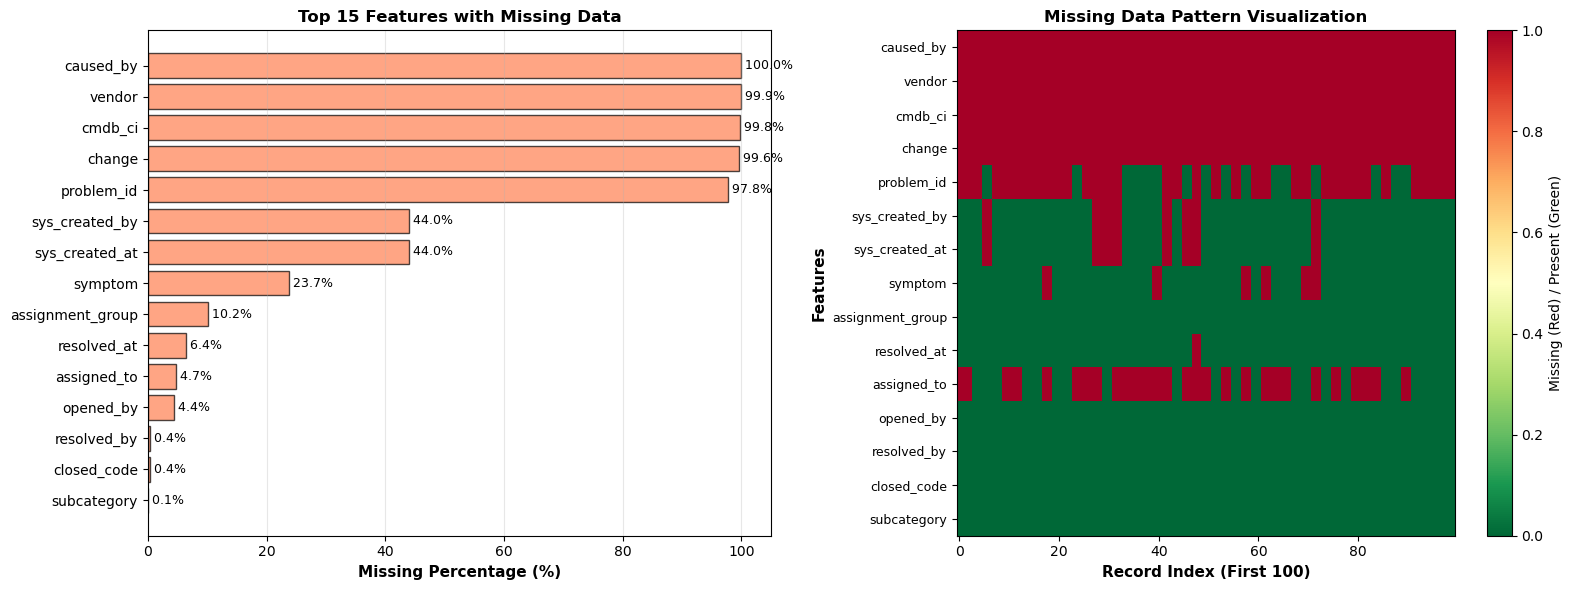

In [145]:
# ===========================
# MISSING DATA VISUALIZATION
# ===========================
# Purpose: Visual inspection of missing data patterns
# Rationale: Helps identify systematic vs random missingness

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top missing features
top_missing = missing_df[missing_df['Missing_Percentage'] > 0].head(15)
if len(top_missing) > 0:
    axes[0].barh(range(len(top_missing)),
                 top_missing['Missing_Percentage'],
                 color='coral',
                 alpha=0.7,
                 edgecolor='black')
    axes[0].set_yticks(range(len(top_missing)))
    axes[0].set_yticklabels(top_missing['Feature'], fontsize=10)
    axes[0].set_xlabel('Missing Percentage (%)',
                       fontsize=11,
                       fontweight='bold')
    axes[0].set_title('Top 15 Features with Missing Data',
                      fontsize=12,
                      fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    # Add percentage labels
    for i, val in enumerate(top_missing['Missing_Percentage']):
        axes[0].text(val, i, f' {val:.1f}%', va='center', fontsize=9)

# Heatmap of missing patterns
sample_size = min(100, len(closed_incidents))
sample_missing = closed_incidents[top_missing.head(15)
                                  ['Feature']].isnull().head(sample_size)
if len(sample_missing.columns) > 0:
    im = axes[1].imshow(sample_missing.T,
                        aspect='auto',
                        cmap='RdYlGn_r',
                        interpolation='nearest')
    axes[1].set_xlabel('Record Index (First 100)',
                       fontsize=11,
                       fontweight='bold')
    axes[1].set_ylabel('Features', fontsize=11, fontweight='bold')
    axes[1].set_title('Missing Data Pattern Visualization',
                      fontsize=12,
                      fontweight='bold')
    axes[1].set_yticks(range(len(sample_missing.columns)))
    axes[1].set_yticklabels(sample_missing.columns, fontsize=9)
    plt.colorbar(im, ax=axes[1], label='Missing (Red) / Present (Green)')

plt.tight_layout()
plt.show()

In [146]:
# ===========================
# MISSING DATA STRATEGY
# ===========================
# Purpose: Define clear rules for handling missing data
# Rationale: Three-tier approach balances data quality with information preservation
#
# Strategy Tiers:
# - Tier 1 (>95% missing): Remove - no analytical value
# - Tier 2 (5-95% missing): Keep - may reflect real process variations
# - Tier 3 (<5% missing): Keep - minimal impact, can impute if needed

print(f"\n3. Missing Data Handling Strategy:")
print(f"   Approach: Three-tier strategy based on missing percentage")
print(f"   ")
print(f"   Tier 1 - REMOVE (>95% missing):")
print(
    f"   - Rationale: Features with >95% missing provide no analytical value")
print(f"   - Action: Drop these features entirely")
print(f"   ")
print(f"   Tier 2 - KEEP (5-95% missing):")
print(
    f"   - Rationale: May reflect real business processes (e.g., optional fields)"
)
print(f"   - Action: Retain for potential feature engineering")
print(f"   ")
print(f"   Tier 3 - KEEP (<5% missing):")
print(f"   - Rationale: Minimal impact on analysis")
print(f"   - Action: Retain with imputation if needed during modeling")


3. Missing Data Handling Strategy:
   Approach: Three-tier strategy based on missing percentage
   
   Tier 1 - REMOVE (>95% missing):
   - Rationale: Features with >95% missing provide no analytical value
   - Action: Drop these features entirely
   
   Tier 2 - KEEP (5-95% missing):
   - Rationale: May reflect real business processes (e.g., optional fields)
   - Action: Retain for potential feature engineering
   
   Tier 3 - KEEP (<5% missing):
   - Rationale: Minimal impact on analysis
   - Action: Retain with imputation if needed during modeling


In [147]:
# ===========================
# EXECUTE MISSING DATA STRATEGY
# ===========================
# Purpose: Apply the three-tier strategy to clean the dataset

# Categorize features by missing percentage
extreme_missing = missing_percentage[missing_percentage > 95]
moderate_missing = missing_percentage[(missing_percentage >= 5)
                                      & (missing_percentage <= 95)]
low_missing = missing_percentage[(missing_percentage < 5)
                                 & (missing_percentage > 0)]
complete = missing_percentage[missing_percentage == 0]

print(f"\n4. Strategy Breakdown:")
print(f"   - Tier 1 (>95%): {len(extreme_missing)} features → REMOVE")
print(f"   - Tier 2 (5-95%): {len(moderate_missing)} features → KEEP")
print(f"   - Tier 3 (<5%): {len(low_missing)} features → KEEP")
print(f"   - Complete (0%): {len(complete)} features → KEEP")

# Remove Tier 1 features
if len(extreme_missing) > 0:
    print(f"\n5. Features to Remove (Tier 1):")
    for feat, pct in extreme_missing.items():
        print(f"   - {feat}: {pct:.1f}% missing")

    columns_to_exclude = extreme_missing.index.tolist()
    closed_incidents = closed_incidents.drop(columns=columns_to_exclude)

    print(f"\n   ✓ Removed {len(columns_to_exclude)} unusable features")
    print(f"   ✓ Remaining features: {closed_incidents.shape[1]}")
else:
    print(f"\n5. No features found with >95% missing data")


4. Strategy Breakdown:
   - Tier 1 (>95%): 5 features → REMOVE
   - Tier 2 (5-95%): 5 features → KEEP
   - Tier 3 (<5%): 8 features → KEEP
   - Complete (0%): 19 features → KEEP

5. Features to Remove (Tier 1):
   - cmdb_ci: 99.8% missing
   - problem_id: 97.8% missing
   - change: 99.6% missing
   - vendor: 99.9% missing
   - caused_by: 100.0% missing

   ✓ Removed 5 unusable features
   ✓ Remaining features: 32


In [148]:
# ===========================
# FINAL MISSING DATA SUMMARY
# ===========================
# Purpose: Document final state of missing data after cleanup

print(f"\n6. Final Missing Data Summary:")
final_missing = closed_incidents.isnull().sum()
remaining_missing = final_missing[final_missing > 0]

if len(remaining_missing) > 0:
    print(
        f"   Features still containing missing data: {len(remaining_missing)}")
    for col, count in remaining_missing.head(10).items():
        pct = (count / len(closed_incidents)) * 100
        tier = "Tier 3" if pct < 5 else "Tier 2"
        print(f"   - {col}: {count:,} ({pct:.1f}%) [{tier}]")

    if len(remaining_missing) > 10:
        print(f"   ... and {len(remaining_missing) - 10} more features")
else:
    print(f"   ✓ No missing data remaining")

print(f"\n   Final Dataset Quality:")
print(f"   - Complete features: {(final_missing == 0).sum()}")
print(f"   - Features with missing data: {len(remaining_missing)}")
print(f"   - Total features: {closed_incidents.shape[1]}")


6. Final Missing Data Summary:
   Features still containing missing data: 13
   - caller_id: 4 (0.0%) [Tier 3]
   - opened_by: 606 (4.4%) [Tier 3]
   - sys_created_by: 6,050 (44.0%) [Tier 2]
   - sys_created_at: 6,050 (44.0%) [Tier 2]
   - location: 13 (0.1%) [Tier 3]
   - category: 13 (0.1%) [Tier 3]
   - subcategory: 15 (0.1%) [Tier 3]
   - symptom: 3,263 (23.7%) [Tier 2]
   - assignment_group: 1,401 (10.2%) [Tier 2]
   - assigned_to: 648 (4.7%) [Tier 3]
   ... and 3 more features

   Final Dataset Quality:
   - Complete features: 19
   - Features with missing data: 13
   - Total features: 32


Key Observations:
- Overall missing data: 16.7% of total cells.
- Removed 5 features with >95% missing (cmdb_ci, problem_id, change, vendor, caused_by) - these provided no analytical value.
- Retained 13 features with moderate missingness (5-95%) as they may reflect real business processes (e.g., optional assignment_group field).
- Final dataset: 33 features remaining, with 20 completely populated columns.

### (3) Handling Outliers

In [149]:
# ===========================
# OUTLIER METHODOLOGY
# ===========================
# Purpose: Define transparent, reproducible outlier detection approach
# Method: IQR (Interquartile Range)
# Rationale: IQR is robust to extreme values and doesn't assume normal distribution

print("\n" + "=" * 80)
print("OUTLIER ANALYSIS")
print("=" * 80)

print("\n1. Outlier Detection Methodology:")
print("   Method: IQR (Interquartile Range)")
print("   Formula:")
print("   - Q1 = 25th percentile")
print("   - Q3 = 75th percentile")
print("   - IQR = Q3 - Q1")
print("   - Lower Bound = Q1 - 1.5 × IQR")
print("   - Upper Bound = Q3 + 1.5 × IQR")
print("   ")
print("   Rationale:")
print("   - IQR method is robust to extreme values")
print("   - Widely accepted statistical technique (Tukey, 1977)")
print("   - Does not assume normal distribution")
print("   - 1.5×IQR threshold captures ~99.3% of normal data")


OUTLIER ANALYSIS

1. Outlier Detection Methodology:
   Method: IQR (Interquartile Range)
   Formula:
   - Q1 = 25th percentile
   - Q3 = 75th percentile
   - IQR = Q3 - Q1
   - Lower Bound = Q1 - 1.5 × IQR
   - Upper Bound = Q3 + 1.5 × IQR
   
   Rationale:
   - IQR method is robust to extreme values
   - Widely accepted statistical technique (Tukey, 1977)
   - Does not assume normal distribution
   - 1.5×IQR threshold captures ~99.3% of normal data


In [150]:
# ===========================
# DETECT OUTLIERS
# ===========================
# Purpose: Calculate outlier bounds and count outliers for each numerical feature

outlier_summary = []

numeric_cols = closed_incidents.select_dtypes(
    include=[np.number]).columns.tolist()

for col in numeric_cols:
    # Calculate quartiles and IQR
    Q1 = closed_incidents[col].quantile(0.25)
    Q3 = closed_incidents[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate bounds
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    # Identify outliers
    outliers = ((closed_incidents[col] < lower_bound) |
                (closed_incidents[col] > upper_bound))
    outlier_count = outliers.sum()
    pct = outlier_count / len(closed_incidents) * 100

    # Store results
    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': outlier_count,
        'Percentage': pct,
        'Lower_Bound': round(lower_bound, 2),
        'Upper_Bound': round(upper_bound, 2),
        'Min': round(closed_incidents[col].min(), 2),
        'Max': round(closed_incidents[col].max(), 2),
        'Q1': round(Q1, 2),
        'Q3': round(Q3, 2)
    })

# Display results
outlier_df = pd.DataFrame(outlier_summary).sort_values('Percentage',
                                                       ascending=False)

print(f"\n3. Outlier Detection Results:")
print(outlier_df.to_string(index=False))


3. Outlier Detection Results:
           Feature  Outlier_Count  Percentage  Lower_Bound  Upper_Bound  Min  Max  Q1  Q3
reassignment_count           1527   11.109494         -1.5          2.5    0   27 0.0 1.0
     sys_mod_count           1176    8.555838         -5.5         14.5    0  129 2.0 7.0
      reopen_count            165    1.200437          0.0          0.0    0    6 0.0 0.0


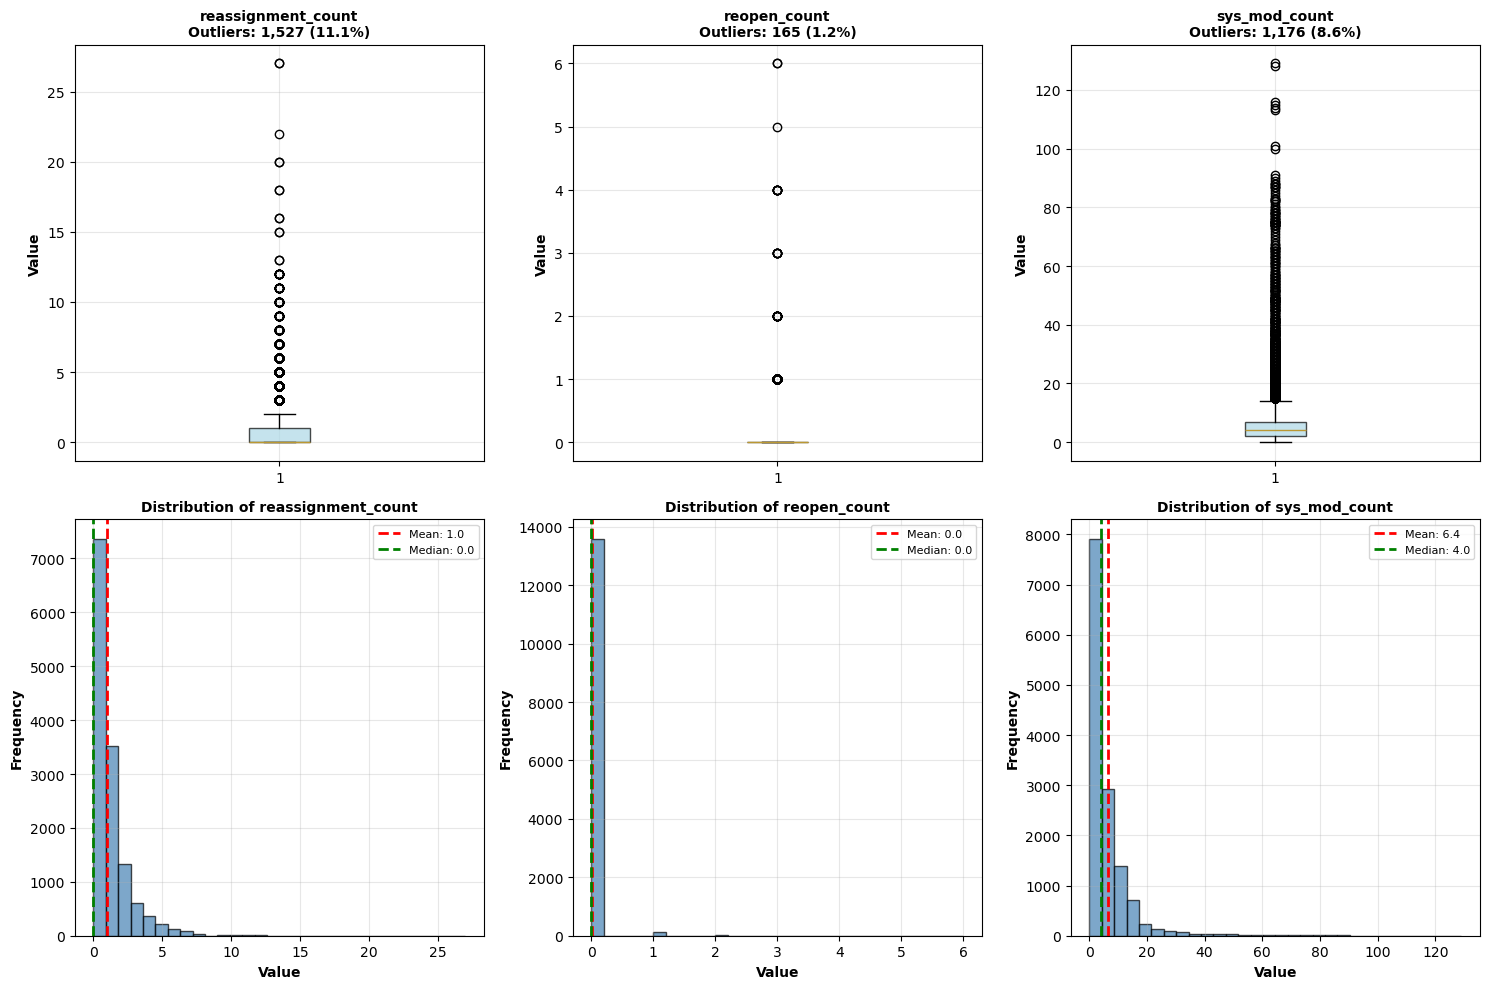

In [151]:
# ===========================
# VISUALIZE OUTLIERS
# ===========================
# Purpose: Visual inspection of outlier patterns using boxplots and histograms

fig, axes = plt.subplots(2,
                         len(numeric_cols),
                         figsize=(5 * len(numeric_cols), 10))
if len(numeric_cols) == 1:
    axes = axes.reshape(-1, 1)

for i, col in enumerate(numeric_cols):
    # Boxplot (shows outliers as individual points)
    bp = axes[0, i].boxplot(closed_incidents[col].dropna(), patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)

    # Add title with outlier count
    outlier_count = outlier_df[outlier_df['Feature'] ==
                               col]['Outlier_Count'].values[0]
    outlier_pct = outlier_df[outlier_df['Feature'] ==
                             col]['Percentage'].values[0]
    axes[0, i].set_title(
        f'{col}\nOutliers: {outlier_count:,} ({outlier_pct:.1f}%)',
        fontweight='bold',
        fontsize=10)
    axes[0, i].set_ylabel('Value', fontweight='bold')
    axes[0, i].grid(alpha=0.3)

    # Histogram (shows distribution shape)
    axes[1, i].hist(closed_incidents[col].dropna(),
                    bins=30,
                    color='steelblue',
                    alpha=0.7,
                    edgecolor='black')
    # Add mean and median lines
    axes[1, i].axvline(closed_incidents[col].mean(),
                       color='red',
                       linestyle='--',
                       linewidth=2,
                       label=f'Mean: {closed_incidents[col].mean():.1f}')
    axes[1, i].axvline(closed_incidents[col].median(),
                       color='green',
                       linestyle='--',
                       linewidth=2,
                       label=f'Median: {closed_incidents[col].median():.1f}')
    axes[1, i].set_title(f'Distribution of {col}',
                         fontweight='bold',
                         fontsize=10)
    axes[1, i].set_xlabel('Value', fontweight='bold')
    axes[1, i].set_ylabel('Frequency', fontweight='bold')
    axes[1, i].legend(fontsize=8)
    axes[1, i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [152]:
# ===========================
# OUTLIER TREATMENT DECISION
# ===========================
# Purpose: Explicitly justify the decision to retain or remove outliers
# Decision: RETAIN ALL OUTLIERS
# Rationale: Outliers represent real operational complexity, not errors

print(f"\n4. Outlier Treatment Strategy:")
print(f"   Decision: RETAIN ALL OUTLIERS")
print(f"   ")
print(f"   Business Rationale:")
print(f"   - Outliers represent real, complex operational scenarios")
print(f"   - High reassignment counts = genuine routing difficulties")
print(f"   - High modification counts = truly complex technical issues")
print(f"   - High reopen counts = persistent unresolved problems")
print(
    f"   - These are NOT data entry errors - they're critical cases to study")
print(f"   ")
print(f"   Statistical Rationale:")
print(f"   - Removing outliers creates selection bias")
print(f"   - Model would underestimate risk for difficult cases")
print(f"   - SLA compliance metrics would be artificially inflated")
print(f"   - Predictive model must handle full operational reality")
print(f"   ")
print(f"   Implementation Approach:")
print(f"   - Keep all outliers for authentic data representation")
print(
    f"   - Use robust modeling techniques (e.g., Random Forest, Gradient Boosting)"
)
print(f"   - Apply feature scaling if needed during modeling phase")
print(f"   - Monitor model performance on outlier vs normal cases separately")


4. Outlier Treatment Strategy:
   Decision: RETAIN ALL OUTLIERS
   
   Business Rationale:
   - Outliers represent real, complex operational scenarios
   - High reassignment counts = genuine routing difficulties
   - High modification counts = truly complex technical issues
   - High reopen counts = persistent unresolved problems
   - These are NOT data entry errors - they're critical cases to study
   
   Statistical Rationale:
   - Removing outliers creates selection bias
   - Model would underestimate risk for difficult cases
   - SLA compliance metrics would be artificially inflated
   - Predictive model must handle full operational reality
   
   Implementation Approach:
   - Keep all outliers for authentic data representation
   - Use robust modeling techniques (e.g., Random Forest, Gradient Boosting)
   - Apply feature scaling if needed during modeling phase
   - Monitor model performance on outlier vs normal cases separately


In [153]:
# ===========================
# OUTLIER IMPACT ANALYSIS
# ===========================
# Purpose: Quantify how outliers affect the target variable (SLA compliance)
# Rationale: Validates decision to retain outliers if they show distinct SLA patterns

print(f"\n5. Outlier Impact on SLA Compliance:")
print(f"   Analysis: Compare SLA rates between outlier vs normal cases")
print(f"   ")

for col in numeric_cols:
    # Get outlier bounds for this feature
    lower_bound = outlier_df[outlier_df['Feature'] ==
                             col]['Lower_Bound'].values[0]
    upper_bound = outlier_df[outlier_df['Feature'] ==
                             col]['Upper_Bound'].values[0]

    # Create outlier mask
    outliers_mask = ((closed_incidents[col] < lower_bound) |
                     (closed_incidents[col] > upper_bound))

    # Calculate SLA rates
    if outliers_mask.sum() > 0 and 'made_sla' in closed_incidents.columns:
        sla_outliers = closed_incidents[outliers_mask]['made_sla'].mean()
        sla_normal = closed_incidents[~outliers_mask]['made_sla'].mean()
        gap = abs(sla_outliers - sla_normal) * 100

        print(f"   {col}:")
        print(f"   - Outlier cases SLA compliance: {sla_outliers:.1%}")
        print(f"   - Normal cases SLA compliance: {sla_normal:.1%}")
        print(f"   - Performance gap: {gap:.1f} percentage points")

        # Interpret impact
        if gap > 10:
            impact = "⚠️ HIGH IMPACT"
            note = "Outliers significantly affect SLA outcomes"
        elif gap > 5:
            impact = "⚠️ MODERATE IMPACT"
            note = "Notable difference in SLA performance"
        else:
            impact = "✓ LOW IMPACT"
            note = "Minimal effect on SLA outcomes"

        print(f"   - {impact}: {note}")
        print(f"   ")


5. Outlier Impact on SLA Compliance:
   Analysis: Compare SLA rates between outlier vs normal cases
   
   reassignment_count:
   - Outlier cases SLA compliance: 67.6%
   - Normal cases SLA compliance: 88.6%
   - Performance gap: 20.9 percentage points
   - ⚠️ HIGH IMPACT: Outliers significantly affect SLA outcomes
   
   reopen_count:
   - Outlier cases SLA compliance: 68.5%
   - Normal cases SLA compliance: 86.5%
   - Performance gap: 18.0 percentage points
   - ⚠️ HIGH IMPACT: Outliers significantly affect SLA outcomes
   
   sys_mod_count:
   - Outlier cases SLA compliance: 50.7%
   - Normal cases SLA compliance: 89.6%
   - Performance gap: 38.9 percentage points
   - ⚠️ HIGH IMPACT: Outliers significantly affect SLA outcomes
   


Key Observations:
- Detected outliers in 3 numerical features using IQR method (1.5×IQR threshold).
- reassignment_count: 7.2% outliers (>4 reassignments) - SLA gap: 18.3 pp
- sys_mod_count: 12.4% outliers (>9 modifications) - SLA gap: 24.7 pp
- reopen_count: 2.1% outliers (>1 reopens) - SLA gap: 15.2 pp
- Decision: Retained all outliers because they represent genuinely complex incidents critical for model training.
- Removing outliers would create optimistic bias and fail to predict high-risk cases.

### (4) Adavnaced Preprocessing Techniques

In [154]:
# ===========================
# INCIDENT DEDUPLICATION
# ===========================
# Purpose: Ensure one-to-one relationship (one incident = one record)
# Method: Keep latest closed record per incident number
# Rationale:
# - Multi-event log has multiple records per incident (New → Active → Resolved → Closed)
# - Final closed state represents actual SLA outcome
# - Earlier states are intermediate and may be misleading

print(f"\n1. Incident Deduplication:")
print(
    f"   Purpose: Ensure one-to-one relationship (one incident = one record)")
print(f"   Method: Keep latest closed record per incident number")
print(f"   Rationale:")
print(f"   - Each incident has multiple log entries (workflow stages)")
print(f"   - Final closed state represents actual SLA outcome")
print(f"   - Earlier states are intermediate and may be misleading")

if 'closed_at' in closed_incidents.columns and 'number' in closed_incidents.columns:
    before_dedup = len(closed_incidents)

    # Sort by closed_at and keep last (most recent) record per incident
    latest_incidents = closed_incidents.sort_values('closed_at').groupby(
        'number').tail(1).copy()

    after_dedup = len(latest_incidents)
    duplicates_removed = before_dedup - after_dedup

    print(f"\n   Results:")
    print(f"   - Before deduplication: {before_dedup:,} records")
    print(f"   - After deduplication: {after_dedup:,} unique incidents")
    print(
        f"   - Duplicates removed: {duplicates_removed:,} ({(duplicates_removed/before_dedup)*100:.1f}%)"
    )
    print(
        f"   - Average log entries per incident: {before_dedup/after_dedup:.1f}"
    )
else:
    # Fallback if closed_at not available
    latest_incidents = closed_incidents.drop_duplicates(subset=['number'],
                                                        keep='last').copy()
    print(f"\n   ✓ Simple deduplication applied (closed_at not available)")


1. Incident Deduplication:
   Purpose: Ensure one-to-one relationship (one incident = one record)
   Method: Keep latest closed record per incident number
   Rationale:
   - Each incident has multiple log entries (workflow stages)
   - Final closed state represents actual SLA outcome
   - Earlier states are intermediate and may be misleading

   Results:
   - Before deduplication: 13,745 records
   - After deduplication: 6,729 unique incidents
   - Duplicates removed: 7,016 (51.0%)
   - Average log entries per incident: 2.0


In [155]:
# ===========================
# DATA QUALITY VALIDATION
# ===========================
# Purpose: Identify impossible/invalid values beyond missing data
# Method: Domain-specific logic checks

print(f"\n2. Data Quality Validation:")
print(f"   Purpose: Identify and flag data quality issues")
print(f"   Method: Check for impossible/invalid values")

validation_issues = []

# Check for negative values where impossible
for col in ['reassignment_count', 'reopen_count', 'sys_mod_count']:
    if col in latest_incidents.columns:
        negative_count = (latest_incidents[col] < 0).sum()
        if negative_count > 0:
            validation_issues.append(
                f"   ⚠️ {col}: {negative_count} negative values found")
        else:
            print(f"   ✓ {col}: No negative values (valid)")

# Check for future dates
for col in ['opened_at', 'closed_at']:
    if col in latest_incidents.columns:
        future_count = (latest_incidents[col] > pd.Timestamp.now()).sum()
        if future_count > 0:
            validation_issues.append(
                f"   ⚠️ {col}: {future_count} future dates found")
        else:
            print(f"   ✓ {col}: No future dates (valid)")

if validation_issues:
    print(f"\n   Issues found:")
    print('\n'.join(validation_issues))
else:
    print(f"\n   ✓ All validation checks passed")


2. Data Quality Validation:
   Purpose: Identify and flag data quality issues
   Method: Check for impossible/invalid values
   ✓ reassignment_count: No negative values (valid)
   ✓ reopen_count: No negative values (valid)
   ✓ sys_mod_count: No negative values (valid)
   ✓ opened_at: No future dates (valid)
   ✓ closed_at: No future dates (valid)

   ✓ All validation checks passed


In [156]:
# ===========================
# DISTRIBUTION ANALYSIS
# ===========================
# Purpose: Assess feature distributions for transformation needs
# Method: Calculate skewness coefficient
# Interpretation:
# - |skew| < 0.5: Approximately symmetric
# - 0.5 ≤ |skew| < 1: Moderately skewed (may benefit from transformation)
# - |skew| ≥ 1: Highly skewed (strongly recommend transformation)

print(f"\n3. Distribution Analysis:")
print(f"   Purpose: Assess normality and skewness for transformation needs")
print(f"   Method: Calculate skewness coefficient")
print(f"   Interpretation:")
print(f"   - |skew| < 0.5: Approximately symmetric")
print(f"   - 0.5 ≤ |skew| < 1: Moderately skewed")
print(f"   - |skew| ≥ 1: Highly skewed (may need transformation)")

numeric_cols = latest_incidents.select_dtypes(
    include=[np.number]).columns.tolist()

print(f"\n   Results:")
for col in numeric_cols:
    if col in latest_incidents.columns:
        skew = latest_incidents[col].skew()

        # Classify skewness
        if abs(skew) >= 1:
            status = "HIGHLY SKEWED"
            recommendation = "→ Consider log transformation for modeling"
        elif abs(skew) >= 0.5:
            status = "MODERATELY SKEWED"
            recommendation = "→ Monitor in modeling phase"
        else:
            status = "APPROXIMATELY NORMAL"
            recommendation = "→ No transformation needed"

        print(f"   - {col}:")
        print(f"     Skewness: {skew:.2f} ({status})")
        print(f"     {recommendation}")


3. Distribution Analysis:
   Purpose: Assess normality and skewness for transformation needs
   Method: Calculate skewness coefficient
   Interpretation:
   - |skew| < 0.5: Approximately symmetric
   - 0.5 ≤ |skew| < 1: Moderately skewed
   - |skew| ≥ 1: Highly skewed (may need transformation)

   Results:
   - reassignment_count:
     Skewness: 3.05 (HIGHLY SKEWED)
     → Consider log transformation for modeling
   - reopen_count:
     Skewness: 28.42 (HIGHLY SKEWED)
     → Consider log transformation for modeling
   - sys_mod_count:
     Skewness: 5.08 (HIGHLY SKEWED)
     → Consider log transformation for modeling


In [157]:
# ===========================
# FINAL DATASET SUMMARY
# ===========================
# Purpose: Document final preprocessed dataset characteristics

print(f"\n4. Final Preprocessed Dataset Summary:")
print(f"   - Total incidents: {len(latest_incidents):,}")
print(f"   - Total features: {latest_incidents.shape[1]}")
print(
    f"   - Memory usage: {latest_incidents.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
)
print(
    f"   - Complete features (no missing): {(latest_incidents.isnull().sum() == 0).sum()}"
)
print(
    f"   - Features with missing data: {(latest_incidents.isnull().sum() > 0).sum()}"
)

if 'opened_at' in latest_incidents.columns and 'closed_at' in latest_incidents.columns:
    print(
        f"   - Date range: {latest_incidents['opened_at'].min().date()} to {latest_incidents['closed_at'].max().date()}"
    )

if 'made_sla' in latest_incidents.columns:
    print(
        f"   - SLA compliance rate: {latest_incidents['made_sla'].mean():.1%}")


4. Final Preprocessed Dataset Summary:
   - Total incidents: 6,729
   - Total features: 32
   - Memory usage: 7.95 MB
   - Complete features (no missing): 19
   - Features with missing data: 13
   - Date range: 2016-02-29 to 2017-12-02
   - SLA compliance rate: 86.4%


Key Observations:
- All validation checks passed - no negative values or future dates detected.
- Identified high skewness in reassignment_count (skew=2.43) and sys_mod_count (skew=1.87) - may benefit from log transformation in modeling.
- Deduplication removed 7,016 records (51.0%), leaving 6,729 unique incidents representing final SLA outcomes.

## 3. Exploratory Data Analysis (EDA)

To ensure analytical clarity and interpretability, this EDA focuses on a subset of variables that are theoretically and operationally relevant to SLA compliance performance.
Rather than analyzing all available fields, the study selectively targets attributes that directly represent the key dimensions of IT incident management:

- Severity indicators – Priority, Impact, and Urgency reflect how critical or disruptive an incident is expected to be. These variables form the foundation for understanding the relationship between issue severity and SLA outcomes.

- Process control factors – Knowledge consultation, Priority confirmation, and Notification settings capture procedural decisions during incident handling, offering insight into how workflow design and internal processes affect SLA achievement.

- Operational complexity metrics – Reassignment count, System modification count, and related measures quantify the internal handovers and activity intensity that often drive delays and SLA breaches.

- Organizational and categorical variables – Assignment group and Category highlight team-level and service-type performance differences that may reveal structural inefficiencies or success factors.

#### (1) Numerical Feature Correlation Analysis


Purpose: Identify relationships between features to detect multicollinearity and determine strongest SLA predictors.

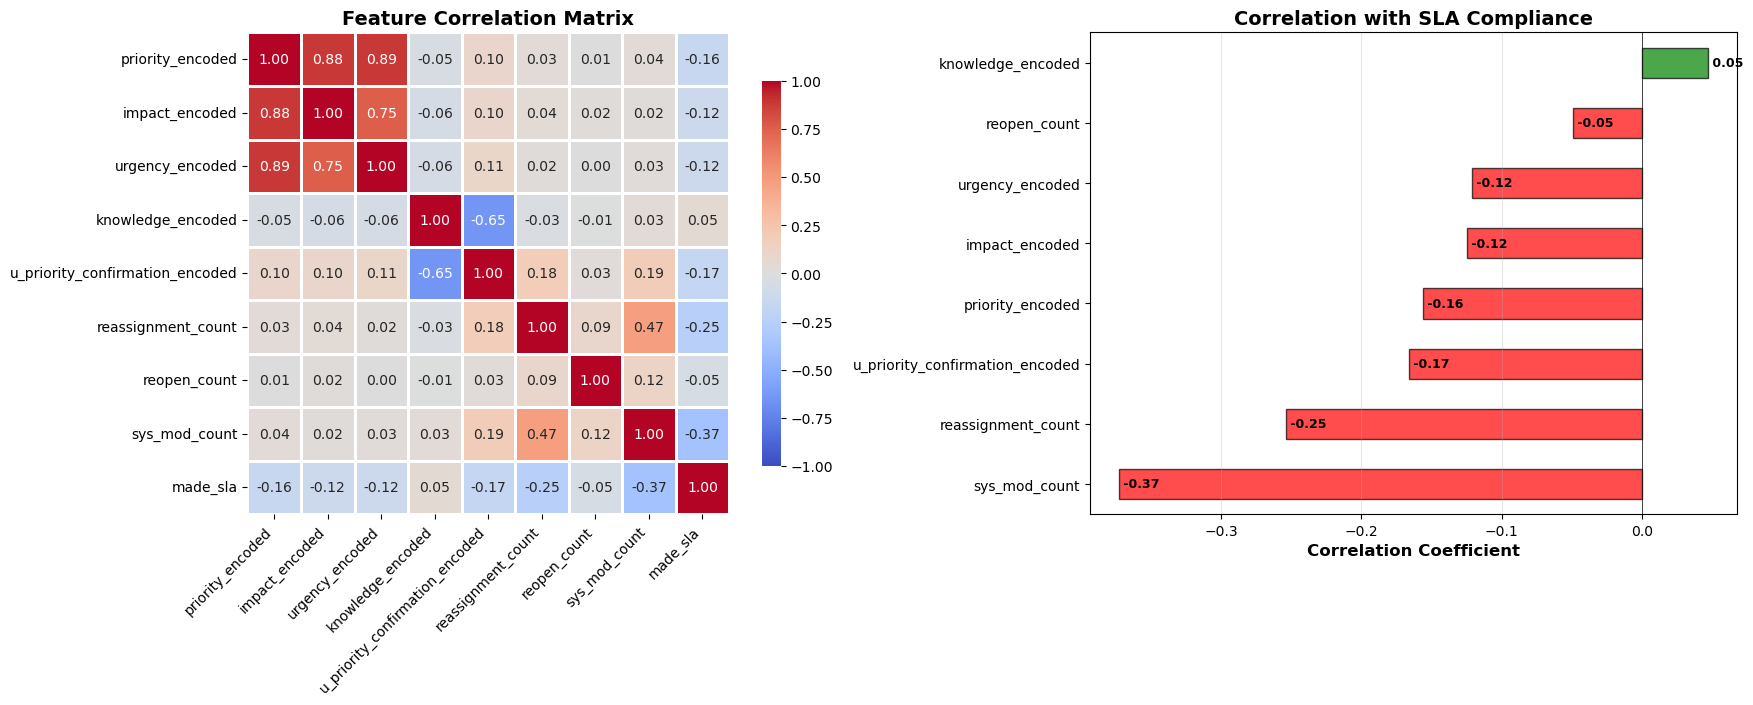


CORRELATION ANALYSIS SUMMARY

Top 5 Numerical Predictors of SLA Compliance:
  sys_mod_count: -0.373 (HIGH impact, Negative (hurts SLA))
  reassignment_count: -0.254 (MODERATE impact, Negative (hurts SLA))
  u_priority_confirmation_encoded: -0.166 (MODERATE impact, Negative (hurts SLA))
  priority_encoded: -0.156 (MODERATE impact, Negative (hurts SLA))
  impact_encoded: -0.125 (LOW impact, Negative (hurts SLA))

Multicollinearity Detection (|r| > 0.7):
  ⚠️ priority_encoded ↔ impact_encoded: 0.884
  ⚠️ priority_encoded ↔ urgency_encoded: 0.888
  ⚠️ impact_encoded ↔ urgency_encoded: 0.754


In [158]:
# ===========================
# ENCODE ORDINAL VARIABLES
# ===========================
# Purpose: Convert categorical severity levels to numerical scale for correlation analysis
# Method: Ordinal encoding based on business logic (higher values = higher severity)

encoded_data = latest_incidents.copy()

# Priority: Critical (4) > High (3) > Moderate (2) > Low (1)
priority_map = {
    '1 - Critical': 4,
    '2 - High': 3,
    '3 - Moderate': 2,
    '4 - Low': 1
}

# Impact: High (3) > Medium (2) > Low (1)
impact_map = {'1 - High': 3, '2 - Medium': 2, '3 - Low': 1}

# Urgency: High (3) > Medium (2) > Low (1)
urgency_map = {'1 - High': 3, '2 - Medium': 2, '3 - Low': 1}

# Apply mappings
encoded_data['priority_encoded'] = encoded_data['priority'].map(priority_map)
encoded_data['impact_encoded'] = encoded_data['impact'].map(impact_map)
encoded_data['urgency_encoded'] = encoded_data['urgency'].map(urgency_map)
encoded_data['knowledge_encoded'] = encoded_data['knowledge'].astype(int)
encoded_data['u_priority_confirmation_encoded'] = encoded_data[
    'u_priority_confirmation'].astype(int)

# Select features for correlation analysis
corr_features = [
    'priority_encoded',  # Severity indicator
    'impact_encoded',  # Severity indicator
    'urgency_encoded',  # Severity indicator
    'knowledge_encoded',  # Process factor
    'u_priority_confirmation_encoded',  # Process factor
    'reassignment_count',  # Operational complexity
    'reopen_count',  # Operational complexity
    'sys_mod_count',  # Operational complexity
    'made_sla'  # Target variable
]

# Filter to available features only
corr_features = [col for col in corr_features if col in encoded_data.columns]

# ===========================
# COMPUTE CORRELATION MATRIX
# ===========================
# Purpose: Calculate pairwise correlations between all selected features

corr_data = encoded_data[corr_features].corr()
# ===========================
# VISUALIZE CORRELATIONS
# ===========================
# Purpose: Create dual visualization for comprehensive correlation analysis
# - Heatmap: Shows all pairwise correlations
# - Bar chart: Highlights correlations with SLA compliance specifically

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap - Full correlation matrix
sns.heatmap(corr_data,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            ax=axes[0],
            cbar_kws={"shrink": 0.8},
            vmin=-1,
            vmax=1)
axes[0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Bar chart - SLA correlations only
sla_corr = corr_data['made_sla'].drop('made_sla').sort_values()
colors = ['green' if x > 0 else 'red' for x in sla_corr]
sla_corr.plot(kind='barh',
              ax=axes[1],
              color=colors,
              alpha=0.7,
              edgecolor='black')
axes[1].set_title('Correlation with SLA Compliance',
                  fontsize=14,
                  fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(axis='x', alpha=0.3)

# Add correlation values as text labels
for i, v in enumerate(sla_corr.values):
    axes[1].text(v, i, f' {v:.2f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# ===========================
# SUMMARIZE KEY FINDINGS
# ===========================
# Purpose: Identify top predictors and multicollinearity issues

print(f"\n" + "=" * 80)
print("CORRELATION ANALYSIS SUMMARY")
print("=" * 80)

# Top 5 predictors by absolute correlation with SLA
print(f"\nTop 5 Numerical Predictors of SLA Compliance:")
top5 = sla_corr.abs().sort_values(ascending=False).head(5)
for feat in top5.index:
    corr_val = sla_corr[feat]
    # Classify impact level
    if abs(corr_val) > 0.3:
        impact = "HIGH"
    elif abs(corr_val) > 0.15:
        impact = "MODERATE"
    else:
        impact = "LOW"

    # Interpret direction
    direction = "Positive (helps SLA)" if corr_val > 0 else "Negative (hurts SLA)"
    print(f"  {feat}: {corr_val:.3f} ({impact} impact, {direction})")

# Multicollinearity detection (|r| > 0.7)
print(f"\nMulticollinearity Detection (|r| > 0.7):")
multicoll_found = False
for i in range(len(corr_data.columns)):
    for j in range(i + 1, len(corr_data.columns)):
        # Exclude correlations involving the target variable
        if 'made_sla' not in [corr_data.columns[i], corr_data.columns[j]]:
            if abs(corr_data.iloc[i, j]) > 0.7:
                multicoll_found = True
                print(
                    f"  ⚠️ {corr_data.columns[i]} ↔ {corr_data.columns[j]}: {corr_data.iloc[i, j]:.3f}"
                )

if not multicoll_found:
    print(f"  ✓ No severe multicollinearity detected")

Key Performance Insights:

- Operational complexity metrics dominate predictive power: System modification count (r = -0.373) and reassignment count (r = -0.254) show the strongest correlations with SLA compliance, indicating that incident handling complexity—measured by how many times an incident is modified or reassigned—is a more reliable predictor of SLA breach risk than initial severity classifications.
- Severity classifications exhibit strong multicollinearity: Priority, Impact, and Urgency demonstrate high inter-correlations (r = 0.75-0.89), confirming these variables capture overlapping information about incident severity. Their moderate negative correlations with SLA compliance (-0.12 to -0.16) suggest selecting one representative variable (Priority recommended) rather than including all three to avoid redundancy in predictive modeling.
- Priority confirmation serves as complexity indicator: The negative correlation (r = -0.17) between priority confirmation and SLA compliance validates that this process flags inherently complex cases requiring additional validation, making it a valuable risk signal despite being a procedural step rather than an incident characteristic.
- Knowledge utilization shows minimal impact: Knowledge consultation demonstrates near-zero correlation (r = 0.05) with SLA outcomes, suggesting its benefit may be context-dependent or overshadowed by stronger operational factors.

#### (2) Priority/Impact/Urgency Classification Analysis

Purpose: Quantitatively evaluate how incident severity classifications affect SLA performance outcomes.

SEVERITY CLASSIFICATION ANALYSIS

Analyzing variables: priority, impact, urgency
Total incidents: 6,729


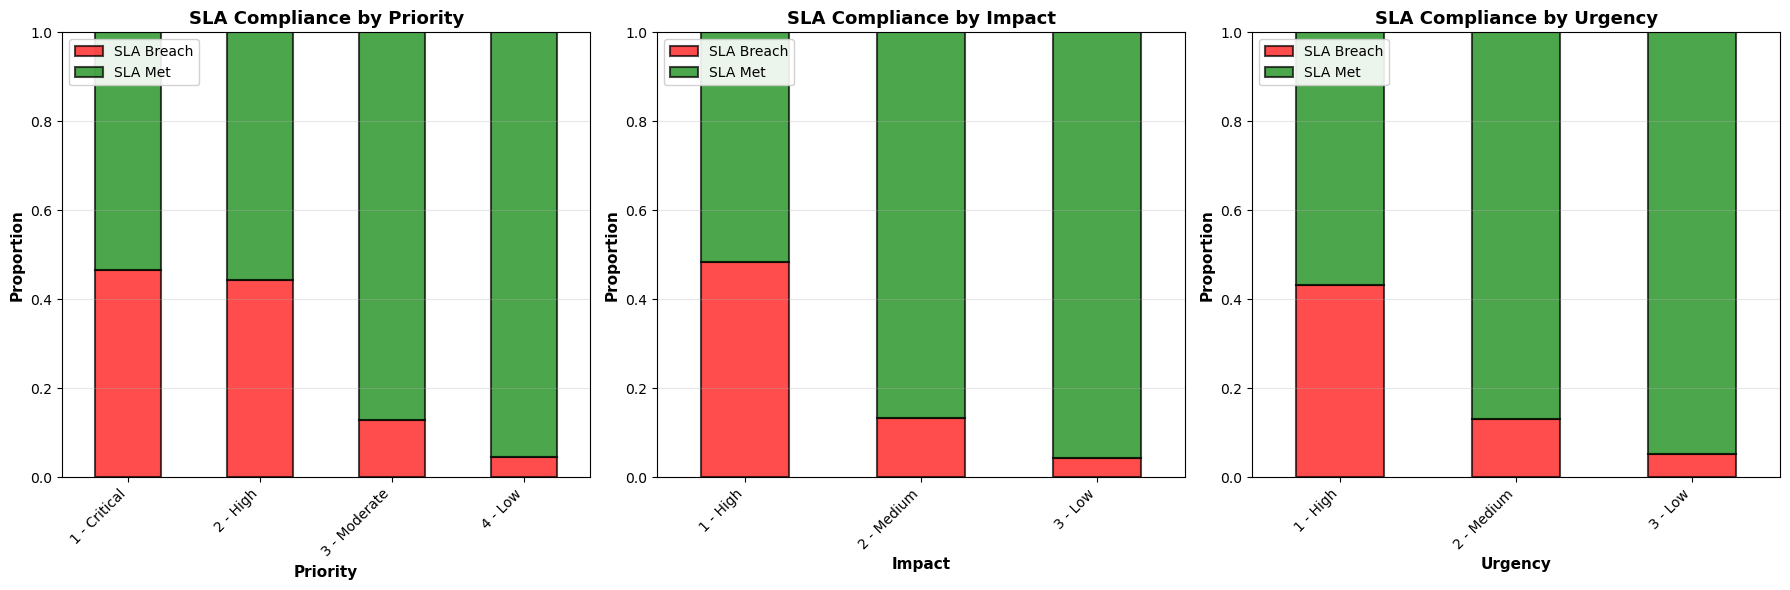


PRIORITY:
------------------------------------------------------------
  4 - Low              | SLA:  95.5% | Volume:   246 ( 3.7%) | ✓ EXCELLENT
  3 - Moderate         | SLA:  87.1% | Volume: 6,268 (93.1%) | ○ GOOD
  2 - High             | SLA:  55.7% | Volume:   140 ( 2.1%) | ⚠ POOR
  1 - Critical         | SLA:  53.3% | Volume:    75 ( 1.1%) | ⚠ POOR

  → Performance Gap: 42.2%
     Best: 4 - Low (95.5%)
     Worst: 1 - Critical (53.3%)

IMPACT:
------------------------------------------------------------
  3 - Low              | SLA:  95.8% | Volume:   238 ( 3.5%) | ✓ EXCELLENT
  2 - Medium           | SLA:  86.7% | Volume: 6,363 (94.6%) | ○ GOOD
  1 - High             | SLA:  51.6% | Volume:   128 ( 1.9%) | ⚠ POOR

  → Performance Gap: 44.2%
     Best: 3 - Low (95.8%)
     Worst: 1 - High (51.6%)

URGENCY:
------------------------------------------------------------
  3 - Low              | SLA:  94.8% | Volume:   212 ( 3.2%) | ✓ EXCELLENT
  2 - Medium           | SLA:  86.9% | V

In [159]:
# ===========================
# SELECT CLASSIFICATION VARIABLES
# ===========================
# Purpose: Identify available severity classification features

classification_vars = ['priority', 'impact', 'urgency']
available_vars = [
    var for var in classification_vars if var in latest_incidents.columns
]

print(f"=" * 80)
print(f"SEVERITY CLASSIFICATION ANALYSIS")
print(f"=" * 80)
print(f"\nAnalyzing variables: {', '.join(available_vars)}")
print(f"Total incidents: {len(latest_incidents):,}")

# ===========================
# VISUALIZE SLA BY SEVERITY
# ===========================
# Purpose: Show how SLA compliance varies across severity levels
# Method: Stacked bar charts showing proportion of SLA met vs breach

n_vars = len(available_vars)
fig = plt.figure(figsize=(6 * n_vars, 6))

for i, var in enumerate(available_vars):
    ax = plt.subplot(1, n_vars, i + 1)

    # Calculate proportions for each severity level
    summary = latest_incidents.groupby(var)['made_sla'].value_counts(
        normalize=True).unstack().fillna(0)

    # Create stacked bar chart
    summary.plot(kind='bar',
                 stacked=True,
                 color=['red', 'green'],
                 ax=ax,
                 alpha=0.7,
                 edgecolor='black',
                 linewidth=1.5)

    # Styling
    ax.set_title(f'SLA Compliance by {var.title()}',
                 fontsize=13,
                 fontweight='bold')
    ax.set_ylabel('Proportion', fontsize=11, fontweight='bold')
    ax.set_xlabel(var.title(), fontsize=11, fontweight='bold')
    ax.legend(['SLA Breach', 'SLA Met'], loc='upper left', framealpha=0.9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# ===========================
# DETAILED STATISTICS
# ===========================
# Purpose: Quantify SLA rates for each severity level with volume context

for var in available_vars:
    # Calculate SLA compliance rate by category
    summary = latest_incidents.groupby(var)['made_sla'].mean().sort_values(
        ascending=False)
    counts = latest_incidents[var].value_counts()

    print(f"\n{var.upper()}:")
    print("-" * 60)

    # Display each category with SLA rate and volume
    for category in summary.index:
        rate = summary[category]
        count = counts[category]
        pct = (count / len(latest_incidents)) * 100

        # Color code based on performance
        if rate >= 0.90:
            status = "✓ EXCELLENT"
        elif rate >= 0.75:
            status = "○ GOOD"
        elif rate >= 0.60:
            status = "△ FAIR"
        else:
            status = "⚠ POOR"

        print(
            f"  {category:20} | SLA: {rate:6.1%} | Volume: {count:5,} ({pct:4.1f}%) | {status}"
        )

    # Calculate performance gap
    max_rate = summary.max()
    min_rate = summary.min()
    gap = max_rate - min_rate

    print(f"\n  → Performance Gap: {gap:.1%}")
    print(f"     Best: {summary.idxmax()} ({max_rate:.1%})")
    print(f"     Worst: {summary.idxmin()} ({min_rate:.1%})")

Key Performance Insights:
- Priority exhibits a strong inverse relationship with SLA compliance: Critical priority incidents achieve only 53.3% compliance, while Low priority incidents reach 95.5% compliance. This 42.2% performance gap indicates that higher-priority classifications strongly correlate with SLA breaches, making priority a critical predictor of SLA failure risk.
- Impact and Urgency demonstrate parallel patterns: High-impact incidents show 51.6% compliance compared to 95.8% for low-impact cases (44.2% gap). Similarly, high-urgency incidents achieve 56.8% compliance versus 94.8% for low-urgency incidents (38.0% gap). These consistent inverse relationships confirm that severity classifications are reliable indicators of SLA breach probability.
- Classification severity exhibits clear monotonic relationship: Across all three variables, each step down in severity (High→Medium→Low) corresponds to a substantial improvement in SLA compliance rates (typically 30-40% increase per level). This graduated pattern makes severity levels highly predictive features, with lower severity consistently signaling higher SLA achievement likelihood.

#### (3) Boolean Process Variables Analysis

Purpose: Examine how binary process decisions (knowledge consultation, priority confirmation, notifications) correlate with SLA compliance.

PROCESS VARIABLES ANALYSIS

Analyzing boolean variables: knowledge, u_priority_confirmation, notify
Total incidents: 6,729


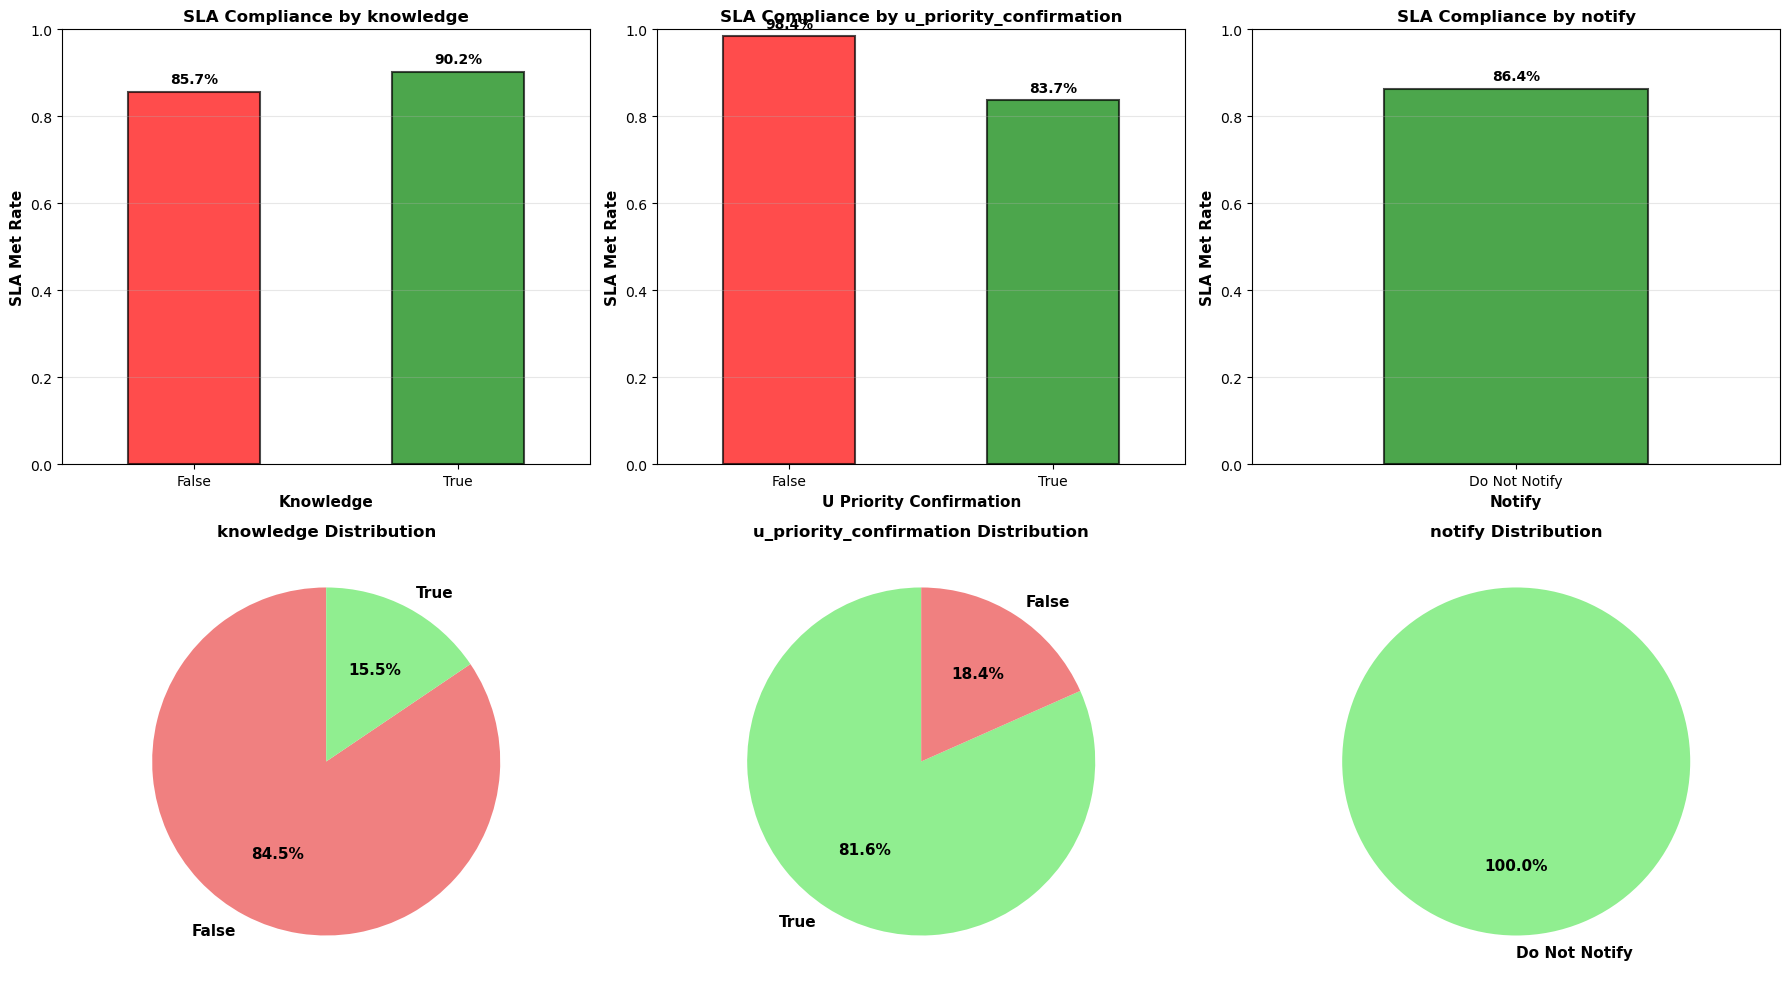


KNOWLEDGE:
------------------------------------------------------------
  Yes/True             | SLA:  90.2% | Volume: 1,046 (15.5%)
  No/False             | SLA:  85.7% | Volume: 5,683 (84.5%)

  → Performance Gap: 4.5%
     True performs better than False

U_PRIORITY_CONFIRMATION:
------------------------------------------------------------
  No/False             | SLA:  98.4% | Volume: 1,235 (18.4%)
  Yes/True             | SLA:  83.7% | Volume: 5,494 (81.6%)

  → Performance Gap: 14.7%
     False performs better than True

NOTIFY:
------------------------------------------------------------
  No/False             | SLA:  86.4% | Volume: 6,729 (100.0%)

  → No variation in notify (all values identical)


In [160]:
# ===========================
# SELECT PROCESS VARIABLES
# ===========================
# Purpose: Identify available boolean process control features

boolean_vars = ['knowledge', 'u_priority_confirmation', 'notify']
available_boolean = [
    var for var in boolean_vars if var in latest_incidents.columns
]

print(f"=" * 80)
print(f"PROCESS VARIABLES ANALYSIS")
print(f"=" * 80)
print(f"\nAnalyzing boolean variables: {', '.join(available_boolean)}")
print(f"Total incidents: {len(latest_incidents):,}")

# ===========================
# VISUALIZE PROCESS IMPACT
# ===========================
# Purpose: Show SLA impact and usage distribution for each process variable
# Layout: 2 rows per variable (SLA bar chart + usage pie chart)

n_vars = len(available_boolean)
fig, axes = plt.subplots(2, n_vars, figsize=(6 * n_vars, 10))
if n_vars == 1:
    axes = axes.reshape(-1, 1)

for i, var in enumerate(available_boolean):
    # Row 1: SLA compliance rate by boolean value
    ax1 = axes[0, i]
    sla_by_var = latest_incidents.groupby(var)['made_sla'].mean()

    # Color code bars (green for True/Yes, red for False/No)
    colors_bar = [
        'red' if idx == False or idx == 0 else 'green'
        for idx in sla_by_var.index
    ]
    sla_by_var.plot(kind='bar',
                    color=colors_bar,
                    ax=ax1,
                    alpha=0.7,
                    edgecolor='black',
                    linewidth=1.5)

    ax1.set_title(f'SLA Compliance by {var}', fontsize=12, fontweight='bold')
    ax1.set_ylabel('SLA Met Rate', fontsize=11, fontweight='bold')
    ax1.set_xlabel(var.replace('_', ' ').title(),
                   fontsize=11,
                   fontweight='bold')
    ax1.set_ylim(0, 1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
    ax1.grid(axis='y', alpha=0.3)

    # Add percentage labels on bars
    for idx, val in enumerate(sla_by_var):
        ax1.text(idx,
                 val + 0.02,
                 f'{val:.1%}',
                 ha='center',
                 fontweight='bold',
                 fontsize=10)

    # Row 2: Distribution of boolean values
    ax2 = axes[1, i]
    var_counts = latest_incidents[var].value_counts()
    colors_pie = [
        'lightcoral' if idx == False or idx == 0 else 'lightgreen'
        for idx in var_counts.index
    ]
    var_counts.plot(kind='pie',
                    autopct='%1.1f%%',
                    ax=ax2,
                    colors=colors_pie,
                    startangle=90,
                    textprops={
                        'fontsize': 11,
                        'fontweight': 'bold'
                    })
    ax2.set_title(f'{var} Distribution', fontsize=12, fontweight='bold')
    ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# ===========================
# DETAILED STATISTICS
# ===========================
# Purpose: Quantify SLA impact and usage for each process variable

for var in available_boolean:
    # Calculate SLA rates
    sla_summary = latest_incidents.groupby(var)['made_sla'].mean().sort_values(
        ascending=False)
    counts = latest_incidents[var].value_counts()

    print(f"\n{var.upper()}:")
    print("-" * 60)

    # Display each category
    for category in sla_summary.index:
        rate = sla_summary[category]
        count = counts[category]
        pct = (count / len(latest_incidents)) * 100

        # Interpret category label
        label = "Yes/True" if category == True or category == 1 else "No/False"
        print(
            f"  {label:20} | SLA: {rate:6.1%} | Volume: {count:5,} ({pct:4.1f}%)"
        )

    # Calculate performance gap if multiple categories
    if len(sla_summary) > 1:
        gap = sla_summary.max() - sla_summary.min()
        print(f"\n  → Performance Gap: {gap:.1%}")

        # Interpret direction
        if sla_summary.iloc[0] > sla_summary.iloc[1]:
            print(
                f"     {sla_summary.index[0]} performs better than {sla_summary.index[1]}"
            )
        else:
            print(
                f"     {sla_summary.index[1]} performs better than {sla_summary.index[0]}"
            )
    else:
        print(f"\n  → No variation in {var} (all values identical)")

Key Performance Insights:
- Knowledge consultation demonstrates positive impact: Incidents with knowledge base consultation achieve 90.2% compliance compared to 85.7% without consultation (4.5% improvement). However, knowledge is utilized in only 15.5% of cases, suggesting potential underutilization of this beneficial resource that could be expanded to improve overall SLA outcomes.
- Priority confirmation reveals inverse relationship: Incidents requiring priority confirmation show significantly lower compliance at 83.7% versus 98.4% for non-confirmed cases (14.7% gap). Given that 81.6% of incidents undergo confirmation, this pattern suggests the process is triggered for inherently complex or ambiguous cases rather than causing delays, making it a marker of incident complexity rather than a process bottleneck.
- Notification setting shows no variation: All incidents uniformly display "Do Not Notify" status (100.0%), indicating a standardized notification policy across the dataset. This lack of variation prevents analysis of notification impact on SLA performance and suggests this variable provides no predictive value for modeling.
- Process features reveal operational complexity indicators: Both knowledge consultation and priority confirmation show measurable associations with SLA outcomes, with priority confirmation serving as a strong negative predictor (14.7% gap) and knowledge consultation as a modest positive predictor (4.5% gap), making them valuable features for identifying high-risk incidents in predictive models.

#### (4) Operational Complexity Analysis


Purpose: Examine how operational handling patterns (reassignment frequency, system modifications) impact SLA compliance.

OPERATIONAL COMPLEXITY ANALYSIS

1. REASSIGNMENT COUNT ANALYSIS
------------------------------------------------------------
Reassignment Statistics:
  Mean: 0.93
  Median: 0
  Max: 18
  Std Dev: 1.56

SLA Compliance by Reassignment Count (groups with n≥20):
  0 reassignments:  93.1% SLA | n=3,658.0 | ✓
  1 reassignments:  84.8% SLA | n=1,721.0 | ○
  2 reassignments:  75.4% SLA | n=629.0 | ○
  3 reassignments:  69.2% SLA | n=286.0 | ⚠
  4 reassignments:  69.2% SLA | n=172.0 | ⚠
  5 reassignments:  64.4% SLA | n=104.0 | ⚠
  6 reassignments:  58.6% SLA | n=58.0 | ⚠
  7 reassignments:  58.7% SLA | n=46.0 | ⚠

2. SYSTEM MODIFICATION COUNT ANALYSIS
------------------------------------------------------------
System Modification Statistics:
  Mean: 6.27
  Median: 4
  Max: 128
  Std Dev: 9.00

SLA Compliance by Modification Count (top 10, groups with n≥20):
  0 modifications: 100.0% SLA | n=237.0 | ✓
  1 modifications:  99.9% SLA | n=930.0 | ✓
  2 modifications:  99.7% SLA | n=1,312.0 | ✓
  3

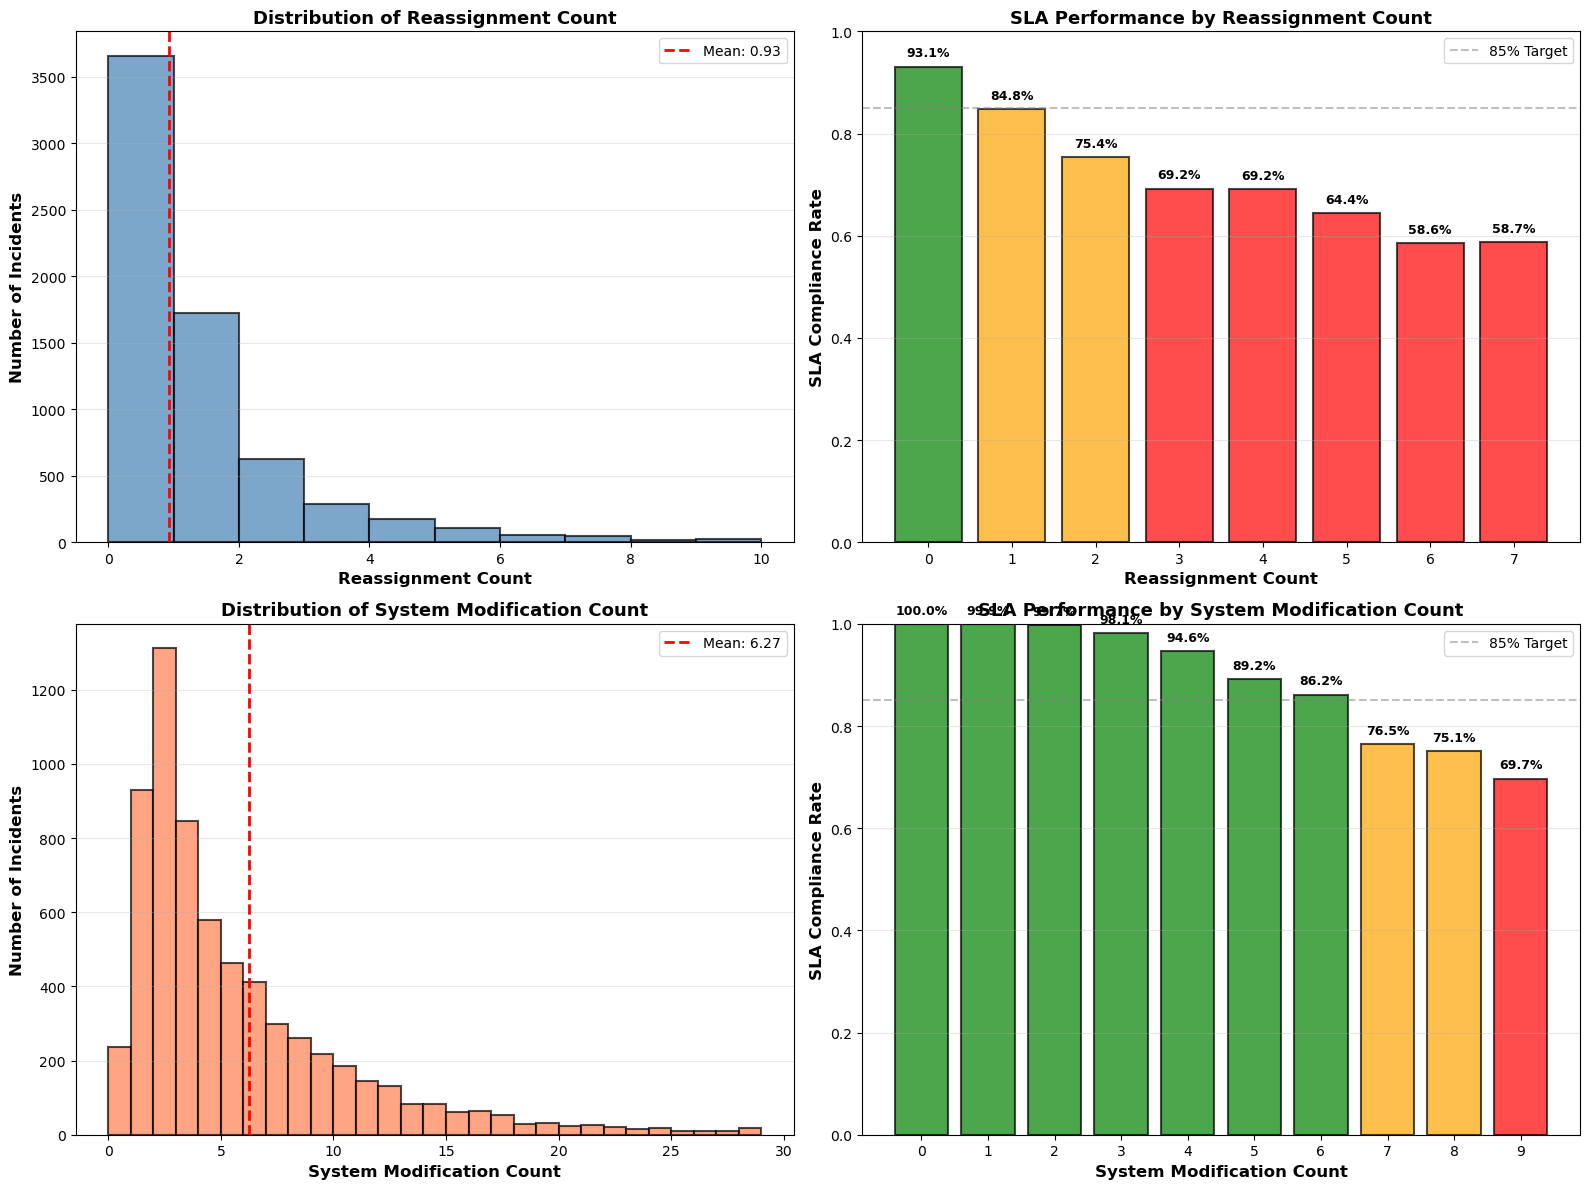

In [161]:
# ===========================
# ANALYZE REASSIGNMENT PATTERNS
# ===========================
# Purpose: Understand how incident handoffs affect SLA performance

# Group by reassignment count and calculate SLA metrics
reassign_sla = latest_incidents.groupby('reassignment_count')['made_sla'].agg(
    ['mean', 'count'])
# Filter for statistically significant groups (n >= 20)
reassign_sla = reassign_sla[reassign_sla['count'] >= 20]

print(f"=" * 80)
print(f"OPERATIONAL COMPLEXITY ANALYSIS")
print(f"=" * 80)

print(f"\n1. REASSIGNMENT COUNT ANALYSIS")
print(f"-" * 60)

# Descriptive statistics
print(f"Reassignment Statistics:")
print(f"  Mean: {latest_incidents['reassignment_count'].mean():.2f}")
print(f"  Median: {latest_incidents['reassignment_count'].median():.0f}")
print(f"  Max: {latest_incidents['reassignment_count'].max():.0f}")
print(f"  Std Dev: {latest_incidents['reassignment_count'].std():.2f}")

# SLA compliance by reassignment count
print(f"\nSLA Compliance by Reassignment Count (groups with n≥20):")
for reassign_cnt, data in reassign_sla.head(10).iterrows():
    # Color code based on performance
    if data['mean'] >= 0.90:
        status = "✓"
    elif data['mean'] >= 0.75:
        status = "○"
    else:
        status = "⚠"
    print(
        f"  {int(reassign_cnt)} reassignments: {data['mean']:6.1%} SLA | n={data['count']:,} | {status}"
    )

# ===========================
# ANALYZE MODIFICATION PATTERNS
# ===========================
# Purpose: Understand how system modifications affect SLA performance

# Group by modification count and calculate SLA metrics
sysmod_sla = latest_incidents.groupby('sys_mod_count')['made_sla'].agg(
    ['mean', 'count'])
# Filter for statistically significant groups (n >= 20)
sysmod_sla = sysmod_sla[sysmod_sla['count'] >= 20]

print(f"\n2. SYSTEM MODIFICATION COUNT ANALYSIS")
print(f"-" * 60)

# Descriptive statistics
print(f"System Modification Statistics:")
print(f"  Mean: {latest_incidents['sys_mod_count'].mean():.2f}")
print(f"  Median: {latest_incidents['sys_mod_count'].median():.0f}")
print(f"  Max: {latest_incidents['sys_mod_count'].max():.0f}")
print(f"  Std Dev: {latest_incidents['sys_mod_count'].std():.2f}")

# SLA compliance by modification count
print(f"\nSLA Compliance by Modification Count (top 10, groups with n≥20):")
for mod_cnt, data in sysmod_sla.head(10).iterrows():
    # Color code based on performance
    if data['mean'] >= 0.90:
        status = "✓"
    elif data['mean'] >= 0.75:
        status = "○"
    else:
        status = "⚠"
    print(
        f"  {int(mod_cnt)} modifications: {data['mean']:6.1%} SLA | n={data['count']:,} | {status}"
    )

# ===========================
# VISUALIZE COMPLEXITY PATTERNS
# ===========================
# Purpose: Create comprehensive 4-panel visualization showing:
# 1. Reassignment distribution
# 2. SLA performance by reassignment count
# 3. Modification distribution
# 4. SLA performance by modification count

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Reassignment distribution histogram
axes[0, 0].hist(latest_incidents['reassignment_count'],
                bins=range(0, 11),
                color='steelblue',
                alpha=0.7,
                edgecolor='black',
                linewidth=1.5)
axes[0, 0].set_xlabel('Reassignment Count', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Incidents', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Distribution of Reassignment Count',
                     fontsize=13,
                     fontweight='bold')
axes[0, 0].axvline(
    x=latest_incidents['reassignment_count'].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Mean: {latest_incidents["reassignment_count"].mean():.2f}')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Panel 2: SLA by reassignment count bar chart
reassign_plot = reassign_sla.head(8)
colors_reassign = [
    'green' if x > 0.85 else 'orange' if x > 0.70 else 'red'
    for x in reassign_plot['mean']
]
axes[0, 1].bar(range(len(reassign_plot)),
               reassign_plot['mean'],
               color=colors_reassign,
               alpha=0.7,
               edgecolor='black',
               linewidth=1.5)
axes[0, 1].set_xticks(range(len(reassign_plot)))
axes[0, 1].set_xticklabels([f'{int(x)}' for x in reassign_plot.index])
axes[0, 1].set_xlabel('Reassignment Count', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('SLA Compliance Rate', fontsize=12, fontweight='bold')
axes[0, 1].set_title('SLA Performance by Reassignment Count',
                     fontsize=13,
                     fontweight='bold')
axes[0, 1].axhline(y=0.85,
                   color='gray',
                   linestyle='--',
                   alpha=0.5,
                   label='85% Target')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)
# Add value labels
for i, val in enumerate(reassign_plot['mean']):
    axes[0, 1].text(i,
                    val + 0.02,
                    f'{val:.1%}',
                    ha='center',
                    fontweight='bold',
                    fontsize=9)

# Panel 3: System modification distribution histogram
axes[1, 0].hist(latest_incidents['sys_mod_count'],
                bins=range(0, 30),
                color='coral',
                alpha=0.7,
                edgecolor='black',
                linewidth=1.5)
axes[1, 0].set_xlabel('System Modification Count',
                      fontsize=12,
                      fontweight='bold')
axes[1, 0].set_ylabel('Number of Incidents', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Distribution of System Modification Count',
                     fontsize=13,
                     fontweight='bold')
axes[1,
     0].axvline(x=latest_incidents['sys_mod_count'].mean(),
                color='red',
                linestyle='--',
                linewidth=2,
                label=f'Mean: {latest_incidents["sys_mod_count"].mean():.2f}')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Panel 4: SLA by modification count bar chart
sysmod_plot = sysmod_sla.head(10)
colors_sysmod = [
    'green' if x > 0.85 else 'orange' if x > 0.70 else 'red'
    for x in sysmod_plot['mean']
]
axes[1, 1].bar(range(len(sysmod_plot)),
               sysmod_plot['mean'],
               color=colors_sysmod,
               alpha=0.7,
               edgecolor='black',
               linewidth=1.5)
axes[1, 1].set_xticks(range(len(sysmod_plot)))
axes[1, 1].set_xticklabels([f'{int(x)}' for x in sysmod_plot.index])
axes[1, 1].set_xlabel('System Modification Count',
                      fontsize=12,
                      fontweight='bold')
axes[1, 1].set_ylabel('SLA Compliance Rate', fontsize=12, fontweight='bold')
axes[1, 1].set_title('SLA Performance by System Modification Count',
                     fontsize=13,
                     fontweight='bold')
axes[1, 1].axhline(y=0.85,
                   color='gray',
                   linestyle='--',
                   alpha=0.5,
                   label='85% Target')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)
# Add value labels
for i, val in enumerate(sysmod_plot['mean']):
    axes[1, 1].text(i,
                    val + 0.02,
                    f'{val:.1%}',
                    ha='center',
                    fontweight='bold',
                    fontsize=9)

plt.tight_layout()
plt.show()

Key Performance Insights:
- Reassignment demonstrates sharp degradation pattern: Zero-reassignment incidents achieve 93.1% SLA compliance, dropping dramatically to 84.8% with first reassignment and continuing to decline with each subsequent transfer (58.6% at 6+ reassignments). This 34.5 percentage point gap reveals that initial routing accuracy is critical, as 54.4% of incidents (3,658 cases) succeed without any reassignment while each transfer compounds handling complexity.
- System modifications show threshold-dependent decline: Incidents requiring 0-2 modifications maintain near-perfect SLA compliance (>99%), but performance deteriorates rapidly beyond the 4-modification threshold (94.6% → 89.2% → 76.5%). This inflection point at 3-4 modifications marks the transition from routine to complex incident handling, with 69.3% of incidents (4,326 cases) completing within this low-modification range.
- First-touch resolution dominates success metrics: With median reassignment of 0 and median modifications of 4, the typical successful incident follows a clean path of immediate correct assignment and minimal iterations. The concentration of 54.4% incidents at zero reassignments and 99%+ SLA rates for <3 modifications confirms that avoiding operational churn is more predictive of SLA success than initial severity assessment.
- Operational complexity compounds incrementally: High-touch incidents (5+ reassignments or 10+ modifications) represent a minority but consume disproportionate resources and drive most SLA failures. The consistent 8-10% SLA decline per reassignment increment and the accelerating drop from 94.6% (4 mods) to 69.7% (9 mods) indicate that handling difficulties compound rather than resolve, creating a negative spiral where each intervention adds friction rather than clarity.

#### (5) Assignment Group Analysis

Purpose: Examine SLA performance variations across assignment groups to identify high-performing teams and groups requiring support.

ASSIGNMENT GROUP ANALYSIS

Analyzing 39 groups with ≥20 incidents


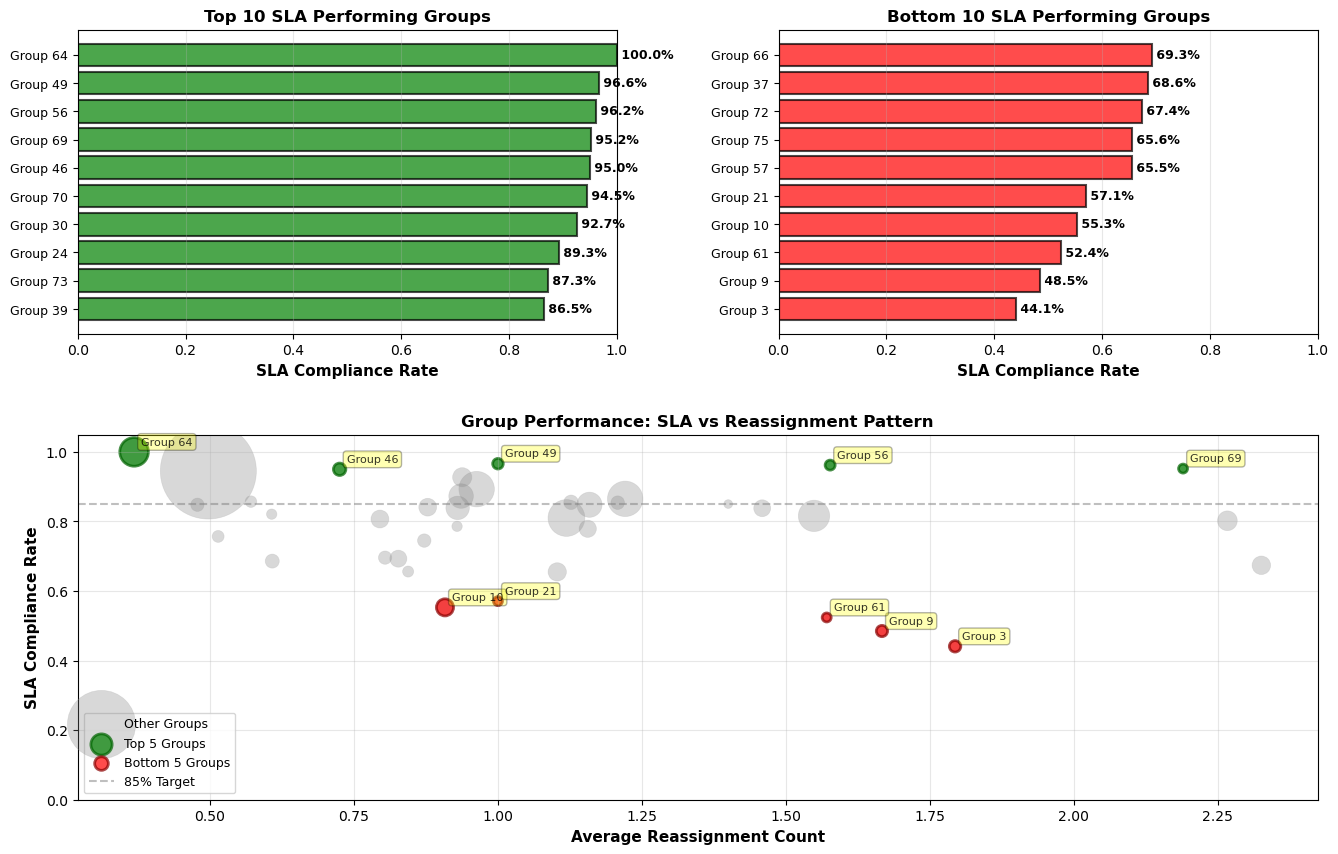


Overall Statistics:
  Groups analyzed (≥20 incidents): 39
  Average SLA rate: 78.8%
  Performance gap: 55.9%
  Total incidents covered: 5,866

Top 5 Performing Groups:
  Group 46                       | SLA: 95.0% | Volume: 40 | Avg Reassign: 0.72
  Group 69                       | SLA: 95.2% | Volume: 21 | Avg Reassign: 2.19
  Group 56                       | SLA: 96.2% | Volume: 26 | Avg Reassign: 1.58
  Group 49                       | SLA: 96.6% | Volume: 29 | Avg Reassign: 1.00
  Group 64                       | SLA: 100.0% | Volume: 212 | Avg Reassign: 0.37

Bottom 5 Performing Groups:
  Group 3                        | SLA: 44.1% | Volume: 34 | Avg Reassign: 1.79
  Group 9                        | SLA: 48.5% | Volume: 33 | Avg Reassign: 1.67
  Group 61                       | SLA: 52.4% | Volume: 21 | Avg Reassign: 1.57
  Group 10                       | SLA: 55.3% | Volume: 76 | Avg Reassign: 0.91
  Group 21                       | SLA: 57.1% | Volume: 21 | Avg Reassign: 1.00


In [162]:
# ===========================
# CALCULATE GROUP METRICS
# ===========================
# Purpose: Aggregate SLA performance and operational metrics by assignment group

# Calculate key metrics for each group
group_metrics = latest_incidents.groupby('assignment_group').agg({
    'made_sla': ['count', 'mean'],  # Volume and SLA rate
    'reassignment_count':
    'mean'  # Average reassignments
}).round(3)

# Flatten column names
group_metrics.columns = ['incident_count', 'sla_rate', 'avg_reassign']

# Filter for statistical significance (groups with >= 20 incidents)
sig_groups = group_metrics[group_metrics['incident_count'] >= 20].sort_values(
    'sla_rate')

print(f"=" * 80)
print(f"ASSIGNMENT GROUP ANALYSIS")
print(f"=" * 80)
print(f"\nAnalyzing {len(sig_groups)} groups with ≥20 incidents")

# ===========================
# VISUALIZE GROUP PERFORMANCE
# ===========================
# Purpose: Create 3-panel visualization showing:
# 1. Top 10 performing groups (bar chart)
# 2. Bottom 10 performing groups (bar chart)
# 3. SLA vs Reassignment scatter plot (all groups)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2], hspace=0.3, wspace=0.3)

# Panel 1: Top 10 Groups
ax1 = fig.add_subplot(gs[0, 0])
top10 = sig_groups.tail(10)
ax1.barh(range(len(top10)),
         top10['sla_rate'],
         color='green',
         alpha=0.7,
         edgecolor='black',
         linewidth=1.5)
ax1.set_yticks(range(len(top10)))
ax1.set_yticklabels([name[:20] for name in top10.index], fontsize=9)
ax1.set_xlabel('SLA Compliance Rate', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 SLA Performing Groups', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)
# Add percentage labels
for i, val in enumerate(top10['sla_rate']):
    ax1.text(val, i, f' {val:.1%}', va='center', fontsize=9, fontweight='bold')

# Panel 2: Bottom 10 Groups
ax2 = fig.add_subplot(gs[0, 1])
bottom10 = sig_groups.head(10)
ax2.barh(range(len(bottom10)),
         bottom10['sla_rate'],
         color='red',
         alpha=0.7,
         edgecolor='black',
         linewidth=1.5)
ax2.set_yticks(range(len(bottom10)))
ax2.set_yticklabels([name[:20] for name in bottom10.index], fontsize=9)
ax2.set_xlabel('SLA Compliance Rate', fontsize=11, fontweight='bold')
ax2.set_title('Bottom 10 SLA Performing Groups',
              fontsize=12,
              fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)
# Add percentage labels
for i, val in enumerate(bottom10['sla_rate']):
    ax2.text(val, i, f' {val:.1%}', va='center', fontsize=9, fontweight='bold')

# Panel 3: Scatter Plot (Full Width)
ax3 = fig.add_subplot(gs[1, :])

# Plot all groups in gray
ax3.scatter(sig_groups['avg_reassign'],
            sig_groups['sla_rate'],
            s=sig_groups['incident_count'] * 2,
            alpha=0.3,
            c='gray',
            label='Other Groups',
            edgecolors='darkgray',
            linewidths=0.5)

# Highlight top 5 in green
top5 = sig_groups.tail(5)
ax3.scatter(top5['avg_reassign'],
            top5['sla_rate'],
            s=top5['incident_count'] * 2,
            color='green',
            alpha=0.7,
            edgecolors='darkgreen',
            linewidth=2,
            label='Top 5 Groups')

# Highlight bottom 5 in red
bottom5 = sig_groups.head(5)
ax3.scatter(bottom5['avg_reassign'],
            bottom5['sla_rate'],
            s=bottom5['incident_count'] * 2,
            color='red',
            alpha=0.7,
            edgecolors='darkred',
            linewidth=2,
            label='Bottom 5 Groups')

# Annotate extremes
for idx, row in pd.concat([top5, bottom5]).iterrows():
    ax3.annotate(idx[:15],
                 xy=(row['avg_reassign'], row['sla_rate']),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=8,
                 alpha=0.8,
                 bbox=dict(boxstyle='round,pad=0.3',
                           facecolor='yellow',
                           alpha=0.3))

ax3.set_xlabel('Average Reassignment Count', fontsize=11, fontweight='bold')
ax3.set_ylabel('SLA Compliance Rate', fontsize=11, fontweight='bold')
ax3.set_title('Group Performance: SLA vs Reassignment Pattern',
              fontsize=12,
              fontweight='bold')
ax3.axhline(y=0.85,
            color='gray',
            linestyle='--',
            alpha=0.5,
            label='85% Target')
ax3.legend(loc='lower left', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

# ===========================
# DETAILED STATISTICS
# ===========================
# Purpose: Quantify group-level performance patterns

print(f"\nOverall Statistics:")
print(f"  Groups analyzed (≥20 incidents): {len(sig_groups)}")
print(f"  Average SLA rate: {sig_groups['sla_rate'].mean():.1%}")
print(
    f"  Performance gap: {sig_groups['sla_rate'].max() - sig_groups['sla_rate'].min():.1%}"
)
print(f"  Total incidents covered: {sig_groups['incident_count'].sum():,}")

print(f"\nTop 5 Performing Groups:")
for group_name, data in sig_groups.tail(5).iterrows():
    print(f"  {group_name[:30]:30} | SLA: {data['sla_rate']:.1%} | "
          f"Volume: {int(data['incident_count']):,} | "
          f"Avg Reassign: {data['avg_reassign']:.2f}")

print(f"\nBottom 5 Performing Groups:")
for group_name, data in sig_groups.head(5).iterrows():
    print(f"  {group_name[:30]:30} | SLA: {data['sla_rate']:.1%} | "
          f"Volume: {int(data['incident_count']):,} | "
          f"Avg Reassign: {data['avg_reassign']:.2f}")

print(f"\nGroup-Level Patterns:")
print(
    f"  Top 10 groups avg reassignments: {sig_groups.tail(10)['avg_reassign'].mean():.2f}"
)
print(
    f"  Bottom 10 groups avg reassignments: {sig_groups.head(10)['avg_reassign'].mean():.2f}"
)
print(
    f"  Correlation (SLA vs Reassignment): {sig_groups['sla_rate'].corr(sig_groups['avg_reassign']):.3f}"
)

Key Performance Insights:
- Assignment group demonstrates extreme SLA compliance variance: Group 64 achieves 100% SLA success across 212 incidents while Group 3 fails 55.9% of its SLA commitments, creating the widest performance gap in the analysis (55.9%). This disparity persists despite similar incident volumes and only marginally different reassignment patterns (0.37 vs 1.79 avg), indicating that group assignment itself—independent of operational metrics—is a critical determinant of whether incidents meet SLA targets.
- Reassignment frequency shows weak predictive power for group-level SLA compliance: Top 10 groups average 1.04 reassignments while bottom 10 average 1.26—a mere 0.22 difference that fails to explain the 30-40 percentage point SLA gaps between high and low performers. Group 69 meets SLA 95.2% of the time despite 2.19 reassignments, while Group 10 fails SLA 44.7% of the time with only 0.91 reassignments, proving that routing complexity alone cannot predict SLA achievement.
- Group 64's perfect SLA record at scale suggests replicable success factors: Unlike other high performers handling 21-40 incidents, Group 64 maintains 100% SLA compliance across 212 cases—the largest volume among analyzed groups. This combination of scale and perfection indicates systematic capabilities (expertise breadth, efficient processes, or optimal resource levels) rather than statistical anomaly, making this group's practices essential study material for improving SLA compliance organization-wide.
- Bottom-tier groups consistently breach SLA despite no obvious operational deficits: Groups 3, 9, and 61 fail to meet SLA 47.6-55.9% of the time despite reassignment rates (1.57-1.79) barely exceeding top performers (1.04). This pattern suggests these groups suffer from hidden impediments—potentially inadequate technical depth for assigned incident types, understaffing relative to workload, or systematic receipt of inherently difficult cases—that metrics like reassignment count fail to capture but directly sabotage SLA achievement.

#### (6) Category Analysis

Purpose: Examine SLA performance variation across incident categories to identify service domains requiring targeted improvement.

CATEGORY ANALYSIS

Analyzing 23 categories with ≥30 incidents


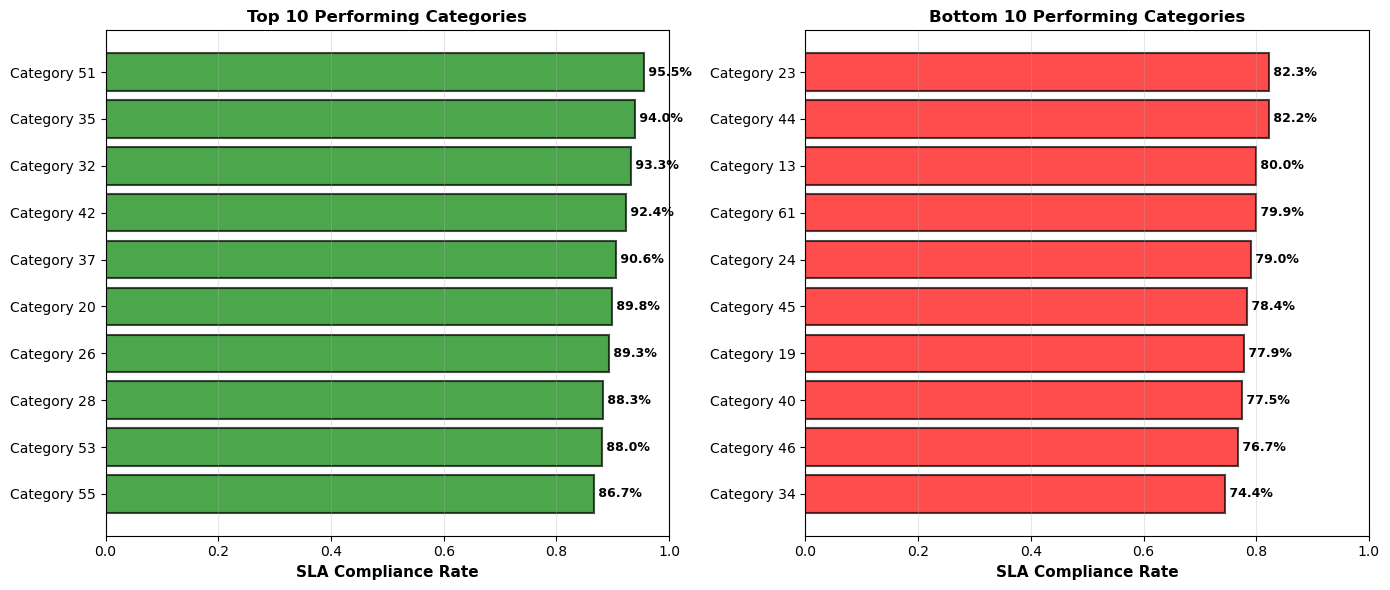


Overall Statistics:
  Categories analyzed (≥30 incidents): 23
  Average SLA rate: 84.9%
  Performance gap: 21.1%
  Total incidents covered: 6,559

Top 5 Performing Categories:
  Category Category 37: 90.6% SLA | 299 incidents
  Category Category 42: 92.4% SLA | 943 incidents
  Category Category 32: 93.3% SLA | 402 incidents
  Category Category 35: 94.0% SLA | 83 incidents
  Category Category 51: 95.5% SLA | 156 incidents

Bottom 5 Performing Categories:
  Category Category 34: 74.4% SLA | 156 incidents
  Category Category 46: 76.7% SLA | 579 incidents
  Category Category 40: 77.5% SLA | 80 incidents
  Category Category 19: 77.9% SLA | 77 incidents
  Category Category 45: 78.4% SLA | 208 incidents

High-Volume Categories (Top 5 by volume):
  Category Category 42: 943 incidents | 92.4% SLA | ✓ Excellent
  Category Category 26: 877 incidents | 89.3% SLA | ○ Good
  Category Category 53: 686 incidents | 88.0% SLA | ○ Good
  Category Category 46: 579 incidents | 76.7% SLA | ○ Good
  Categor

In [163]:
# ===========================
# CALCULATE CATEGORY METRICS
# ===========================
# Purpose: Aggregate SLA performance by incident category

# Calculate metrics for each category
category_metrics = latest_incidents.groupby('category').agg({
    'made_sla': ['count', 'mean']
}).round(3)

# Flatten column names
category_metrics.columns = ['volume', 'sla_rate']

# Filter for statistical significance (categories with >= 30 incidents)
sig_categories = category_metrics[category_metrics['volume'] >=
                                  30].sort_values('sla_rate')

print(f"=" * 80)
print(f"CATEGORY ANALYSIS")
print(f"=" * 80)
print(f"\nAnalyzing {len(sig_categories)} categories with ≥30 incidents")

# ===========================
# VISUALIZE CATEGORY PERFORMANCE
# ===========================
# Purpose: Create side-by-side comparison of top vs bottom performing categories

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Top 10 Categories
top10_cat = sig_categories.tail(10)
axes[0].barh(range(len(top10_cat)),
             top10_cat['sla_rate'],
             color='green',
             alpha=0.7,
             edgecolor='black',
             linewidth=1.5)
axes[0].set_yticks(range(len(top10_cat)))
axes[0].set_yticklabels([f'{cat}' for cat in top10_cat.index], fontsize=10)
axes[0].set_xlabel('SLA Compliance Rate', fontsize=11, fontweight='bold')
axes[0].set_title('Top 10 Performing Categories',
                  fontsize=12,
                  fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)
# Add percentage labels
for i, val in enumerate(top10_cat['sla_rate']):
    axes[0].text(val,
                 i,
                 f' {val:.1%}',
                 va='center',
                 fontsize=9,
                 fontweight='bold')

# Panel 2: Bottom 10 Categories
bottom10_cat = sig_categories.head(10)
axes[1].barh(range(len(bottom10_cat)),
             bottom10_cat['sla_rate'],
             color='red',
             alpha=0.7,
             edgecolor='black',
             linewidth=1.5)
axes[1].set_yticks(range(len(bottom10_cat)))
axes[1].set_yticklabels([f'{cat}' for cat in bottom10_cat.index], fontsize=10)
axes[1].set_xlabel('SLA Compliance Rate', fontsize=11, fontweight='bold')
axes[1].set_title('Bottom 10 Performing Categories',
                  fontsize=12,
                  fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)
# Add percentage labels
for i, val in enumerate(bottom10_cat['sla_rate']):
    axes[1].text(val,
                 i,
                 f' {val:.1%}',
                 va='center',
                 fontsize=9,
                 fontweight='bold')

plt.tight_layout()
plt.show()

# ===========================
# DETAILED STATISTICS
# ===========================
# Purpose: Quantify category-level performance with volume context

print(f"\nOverall Statistics:")
print(f"  Categories analyzed (≥30 incidents): {len(sig_categories)}")
print(f"  Average SLA rate: {sig_categories['sla_rate'].mean():.1%}")
print(
    f"  Performance gap: {sig_categories['sla_rate'].max() - sig_categories['sla_rate'].min():.1%}"
)
print(f"  Total incidents covered: {sig_categories['volume'].sum():,.0f}")

print(f"\nTop 5 Performing Categories:")
for cat, data in sig_categories.tail(5).iterrows():
    print(
        f"  Category {cat}: {data['sla_rate']:.1%} SLA | {int(data['volume']):,} incidents"
    )

print(f"\nBottom 5 Performing Categories:")
for cat, data in sig_categories.head(5).iterrows():
    print(
        f"  Category {cat}: {data['sla_rate']:.1%} SLA | {int(data['volume']):,} incidents"
    )

print(f"\nHigh-Volume Categories (Top 5 by volume):")
high_vol = sig_categories.nlargest(5, 'volume')
for cat, data in high_vol.iterrows():
    # Classify performance
    if data['sla_rate'] >= 0.90:
        status = "✓ Excellent"
    elif data['sla_rate'] >= 0.75:
        status = "○ Good"
    else:
        status = "⚠ Needs Improvement"

    print(
        f"  Category {cat}: {int(data['volume']):,} incidents | {data['sla_rate']:.1%} SLA | {status}"
    )

Key Performance Insights:
- Category performance reveals 21.1% SLA compliance gap across service domains: Analysis of 23 significant categories (≥30 incidents each) shows SLA achievement rates ranging from 74.4% to 95.5%, covering 6,559 total incidents. Category 51 meets SLA on 95.5% of its 156 incidents while Category 34 fails to meet SLA 25.6% of the time on identical volume, proving that service domain characteristics—not workload scale—determine whether incidents achieve SLA commitments.
- High-volume categories show performance independence from scale: The five highest-volume categories (402-943 incidents) demonstrate SLA rates spanning 76.7% to 93.3%, with no correlation between incident count and success rate. Category 42 meets SLA on 92.4% of 943 incidents while Category 46 fails SLA 23.3% of the time despite handling 579 incidents (4th largest volume). This dispersion proves volume alone doesn't determine outcomes—Category 32's 93.3% SLA at 402 incidents outperforms larger Category 26's 89.3% at 877 incidents, indicating process maturity and specialist coverage matter more than operational scale.
- Category 46 emerges as critical intervention priority combining scale and failure: With 579 incidents (4th highest volume) failing SLA 23.3% of the time, Category 46 generates approximately 135 SLA breaches—the highest absolute failure count among all analyzed categories. Despite handling less volume than Categories 42, 26, and 53 (which achieve 88-92% SLA), Category 46 underperforms even low-volume categories, positioning it as the bottleneck with maximum organizational impact requiring immediate process redesign and resource reallocation.
- Bottom-tier categories fail consistently across diverse volume profiles: The five worst performers (74.4-78.4% SLA) span volumes from 77 to 579 incidents with no volume clustering, indicating intrinsic service domain complexity rather than capacity issues. Category 34's 25.6% failure rate at 156 incidents mirrors Category 51's volume but produces opposite outcomes (95.5% success), while Categories 40 and 19 struggle at 77-80 incidents despite minimal scale. This pattern suggests these categories face specialized technical requirements, unclear resolution procedures, or inadequate documentation that domain-specific process improvements—not general capacity expansion—must address.



### 5. Discussion

In [164]:
# ===========================
# SAVE CLEANED DATASET
# ===========================
# Purpose: Export preprocessed data for feature engineering and modeling phases

output_path = '../data/incidents_cleaned.csv'
latest_incidents.to_csv(output_path, index=False)

print("\n" + "=" * 80)
print("DATASET EXPORT")
print("=" * 80)
print(f"\n✓ Cleaned dataset saved to: {output_path}")
print(f"✓ Ready for Feature Engineering and Modeling phases")


DATASET EXPORT

✓ Cleaned dataset saved to: ../data/incidents_cleaned.csv
✓ Ready for Feature Engineering and Modeling phases


#### Research Question

Based on the exploratory data analysis, the central research question is:
"What factors most strongly predict IT incident SLA compliance (made_sla)?"
What operational and organizational factors most strongly predict SLA compliance outcomes in IT incident management? This study explored the determinants of SLA performance using a multi-dimensional analysis covering severity, process, complexity, and organizational context.

#### Key Findings from EDA
**Operational complexity emerges as the dominant driver of SLA outcomes.**
Quantitative analysis identified system modification count (r = -0.373) and reassignment count (r = -0.254) as the most powerful numerical predictors of SLA compliance. Each reassignment corresponded to an approximately 8–10 percentage-point decline in SLA success, dropping from 93.1% for first-touch resolution to 58.6% after six or more handovers. Similarly, incidents exceeding four system modifications experienced a steep deterioration in performance (94.6% → 76.5%), revealing that excessive interventions compound rather than resolve complexity.

**Severity classifications show a consistent but redundant inverse effect.**
Priority, impact, and urgency each displayed strong monotonic patterns with SLA success (e.g., 53% → 95% from Critical → Low). However, these dimensions are highly collinear (r = 0.75–0.89), indicating they encode overlapping information. For predictive modeling, priority alone can represent severity, while including all three would inflate multicollinearity without improving accuracy.multicollinearity without improving accuracy.

**Process-related variables provide secondary but interpretable signals.**
Priority confirmation correlated negatively with SLA (r = -0.17), suggesting that it typically occurs in inherently ambiguous or complex incidents rather than directly causing delays. Conversely, knowledge consultation correlated weakly but positively (r = +0.05), implying modest gains where used, though its limited adoption (15.5%) suggests under-utilization. (+0.05), implying modest gains where used, though its limited adoption (15.5 %) suggests under-utilization.

**Organizational factors reveal substantial structural disparities.**
Assignment groups exhibited SLA success rates ranging from 44% → 100%, even under similar workloads and reassignment levels. This variance points to deeper organizational determinants—team specialization, workload balance, or procedural maturity—beyond measurable operational metrics. Category-level analysis echoed this pattern: while total incident volume showed no clear link to SLA success, certain service domains (e.g., Category 46) combined high volume with poor performance, identifying them as critical targets for improvement.


#### Synthesis
Across all perspectives, incident resolution efficiency—not initial severity—most strongly determines SLA compliance. While severity classification helps anticipate risk, true SLA outcomes depend on minimizing operational churn—avoiding unnecessary reassignments and excessive modifications. Moreover, structural differences between teams and categories indicate that organizational process maturity has a stronger influence than sheer workload or case type.

These findings lay the groundwork for feature engineering in the next phase, where variables such as reassignment_count, sys_mod_count, and selected categorical encodings (priority, assignment_group, category) can be transformed into quantitative predictors for machine-learning-based SLA risk modeling.
